In [92]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-v0_8-paper")

# Load results

In [93]:
def load_experiment_results(
    paths, root_dir: str, transfer_only: bool = False
) -> pd.DataFrame:
    """
    Load experiment results from given paths in the ccs_reporters_dir.
    Can handle paths to both individual experiment directories and sweep directories.

    Args:
    paths (list of str): Relative paths in the ccs_reporters_dir.

    Returns:
    pd.DataFrame: DataFrame with the experiment results.
    """
    all_data = []

    for path in paths:
        full_path = os.path.join(root_dir, path)

        for dirpath, dirnames, filenames in os.walk(full_path):
            if "eval.csv" not in filenames:
                continue

            # Extract model and dataset from the path
            parts = dirpath.replace(root_dir, "").strip("/").split("/")

            if "transfer" in dirpath:
                eval_datasets = parts[-1]
                train_dataset = parts[-3]
                if len(parts) == 6:
                    model = parts[-4]
                elif len(parts) == 7:
                    model = os.path.join(*parts[-5:-3])
                else:
                    raise ValueError(f"Unexpected transfer path: {dirpath}")
            elif not transfer_only:
                train_dataset = eval_datasets = parts[-1]
                if len(parts) == 4:
                    model = parts[-2]
                elif len(parts) == 5:
                    model = os.path.join(*parts[-3:-1])
                else:
                    raise ValueError(f"Unexpected path: {dirpath}")
            else:
                continue

            if "+" in train_dataset:
                raise ValueError(
                    f"Training on multiple datasets is not supported. Path: {dirpath}"
                )
            eval_datasets = sorted(eval_datasets.split("+"))

            # Load eval.csv
            eval_df = pd.read_csv(os.path.join(dirpath, "eval.csv"))
            original_eval_df_columns = eval_df.columns.to_list()
            # Prepend "eval_" to all columns. Note that "dataset" is renamed to
            # "eval_dataset".
            eval_df.columns = ["eval_" + col for col in eval_df.columns]

            # Load lr_eval.csv
            lr_eval_df = pd.read_csv(os.path.join(dirpath, "lr_eval.csv"))
            lr_eval_df.columns = [
                "lr_eval_" + col for col in lr_eval_df.columns
            ]

            # Load lm_eval.csv if exists
            lm_eval_file = os.path.join(dirpath, "lm_eval.csv")
            lm_eval_exists = os.path.exists(lm_eval_file)
            if lm_eval_exists:
                lm_eval_df = pd.read_csv(lm_eval_file)
                lm_eval_df.columns = [
                    "lm_eval_" + col for col in lm_eval_df.columns
                ]
            else:
                lm_eval_df = pd.DataFrame(
                    columns=[
                        "lm_eval_" + col for col in original_eval_df_columns
                    ]
                )
                lm_eval_df.loc[0] = [pd.NA] * len(lm_eval_df.columns)

            eval_df_datasets = eval_df["eval_dataset"]
            unique_eval_df_datasets = sorted(eval_df_datasets.unique())
            lr_eval_df_datasets = lr_eval_df["lr_eval_dataset"]
            lm_eval_df_datasets = lm_eval_df["lm_eval_dataset"]
            if not eval_datasets == unique_eval_df_datasets:
                raise ValueError(
                    "Expected eval.csv to have eval datasets that math the "
                    f"directory name. Found {unique_eval_df_datasets} for directory "
                    f"{dirpath}"
                )
            if not (
                (eval_df_datasets == lr_eval_df_datasets).all()
                and (
                    not lm_eval_exists
                    or (eval_df_datasets == lm_eval_df_datasets).all()
                )
            ):
                raise ValueError(
                    "Expected all eval CSVs to have matching eval datasets."
                )

            # Drop eval dataset column from LR and LM eval dataframes, only
            # keeping "eval_dataset" in eval_df.
            lr_eval_df.drop(columns=["lr_eval_dataset"], inplace=True)
            lm_eval_df.drop(columns=["lm_eval_dataset"], inplace=True)

            # Combine all dataframes
            combined_df = pd.concat([eval_df, lr_eval_df, lm_eval_df], axis=1)
            combined_df["model"] = model
            combined_df["dataset"] = train_dataset
            combined_df["path"] = dirpath.replace(root_dir, "").strip("/")

            all_data.append(combined_df)

    return pd.concat(all_data, ignore_index=True)

In [94]:
# CS 281A final project
# paths = [
#     "sweeps/fervent-heisenberg",
#     "sweeps/thirsty-wing",
#     "sweeps/gallant-davinci",
# ]

# Reproduce Burns et al., IMBD and AG-News. Includes inference bug fix for
# ensembling = "none" and Burns style eval (ensembling = "burns").
# paths = ["sweeps/crazy-galileo-burns-eval"]
# Copy of the above for testing.
# paths = ["sweeps/crazy-galileo-burns-eval-copy"]
# Reproduce Burns et al., all datasets. Not all experiments finished succesfully.
# paths = ["sweeps/serene-montalcini"]

# No Platt scaling
# paths = ["sweeps/cranky-shtern"]

paths = ["sweeps/magical-pascal"]

root_dir = "/accounts/projects/jsteinhardt/ebronstein/ccs-reporters"
transfer_only = True

results_df = load_experiment_results(
    paths, root_dir, transfer_only=transfer_only
)

/tmp/ipykernel_2193523/3621607958.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_data, ignore_index=True)


In [95]:
results_df_without_transfer = results_df[
    results_df["dataset"] == results_df["eval_dataset"]
]

# Constants and helper functions

In [96]:
ENSEMBLING_MODES = ("none", "burns", "partial", "full")

METRIC_TO_LABEL = {
    "acc_estimate": "Accuracy",
    "cal_acc_estimate": "Calibrated Accuracy",
    "auroc_estimate": "AUROC",
    "ece": "ECE",
}

DATASET_TO_LABEL = {
    "ag_news": "AG-News",
    "imdb": "IMDB",
    "glue:qnli": "QNLI",
    "super_glue:boolq": "BoolQ",
    "super_glue:copa": "COPA",
    "super_glue:rte": "RTE",
    "swag:regular": "SWAG",
}
LABEL_TO_DATASET = {v: k for k, v in DATASET_TO_LABEL.items()}

MODEL_TO_LABEL = {
    "EleutherAI/gpt-j-6B": "GPT-J",
    "gpt2-xl": "GPT-2 XL",
    "microsoft/deberta-v2-xxlarge-mnli": "DeBERTa",
    "roberta-large-mnli": "RoBERTa",
}

In [97]:
DATASET_ORDER = [
    "imdb",
    "amazon_polarity",
    "ag_news",
    "dbpedia_14",
    "super_glue:copa",
    "super_glue:rte",
    "super_glue:boolq",
    "glue:qnli",
    "piqa",
]


def get_dataset_order(dataset: str):
    # Get the full dataset name if `dataset` is a label.
    dataset_name = LABEL_TO_DATASET.get(dataset, dataset)
    return DATASET_ORDER.index(dataset_name)


def get_dataset_order_series(datasets: pd.Series):
    return datasets.map(get_dataset_order)

# get_best_metric_per_model_and_dataset

In [98]:
def get_best_metric_per_model_and_dataset(
    df, metric: str, layer=None, ensembling=None
):
    metric_options = [
        "acc_estimate",
        "cal_acc_estimate",
        "auroc_estimate",
        "ece",
    ]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")
    # If layer is specified, filter by layer
    if layer is not None:
        df = df[
            (df["eval_layer"] == layer)
            & (df["lr_eval_layer"] == layer)
            & (df["lm_eval_layer"] == layer)
        ]
    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]
    # Group by model and dataset, and take the min if ECE, max if accuracy or AUROC.
    grouped_df = df.groupby(["model", "dataset"])
    grouped_df = grouped_df.min() if metric == "ece" else grouped_df.max()
    return grouped_df

# Metric per model, per dataset

In [99]:
def plot_grouped_accuracy_by_model_with_labels(
    df, layer=None, ensembling=None, metric: str = "acc_estimate"
):
    """
    Creates a figure with subplots for each model showing grouped bar plots
    of the average accuracy of CCS, LR, and Zero-Shot for each dataset, with accuracy labels on top of each bar.

    Args:
        df (pd.DataFrame): DataFrame with experiment results.
        metric: "acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece".
    """
    metric_options = [
        "acc_estimate",
        "cal_acc_estimate",
        "auroc_estimate",
        "ece",
    ]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")

    metric_cols = [
        f"{method}_{metric}" for method in ["eval", "lr_eval", "lm_eval"]
    ]
    method_mapping = {
        k: v for k, v in zip(metric_cols, ["CCS", "LR", "Zero-Shot"])
    }

    # Filter relevant columns
    df = df[
        [
            "model",
            "dataset",
            *metric_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    grouped_df = get_best_metric_per_model_and_dataset(
        df, metric, layer=layer, ensembling=ensembling
    ).reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create subplots
    fig, axes = plt.subplots(
        1, len(models), figsize=(5 * len(models), 5), sharex=True
    )

    if len(models) == 1:
        axes = [axes]  # Ensure axes is always a list

    # Create a color palette
    palette = ["blue", "orange", "green"]

    for ax, model in zip(axes, models):
        # Filter data for this model
        model_df = grouped_df[grouped_df["model"] == model]

        # Melt the DataFrame for easy plotting
        melted_df = model_df.melt(
            id_vars=["model", "dataset"],
            value_vars=metric_cols,
            var_name="method",
            value_name="metric",
        )

        # Map methods to more readable names
        melted_df["method"] = melted_df["method"].map(method_mapping)
        melted_df["model"] = melted_df["model"].map(
            lambda x: MODEL_TO_LABEL.get(x, x)
        )
        melted_df["dataset"] = melted_df["dataset"].map(
            lambda x: DATASET_TO_LABEL.get(x, x)
        )

        # Plot grouped bar plot
        bars = sns.barplot(
            data=melted_df,
            x="dataset",
            y="metric",
            hue="method",
            palette=palette,
            ax=ax,
        )

        # Add text labels on top of each bar
        for bar in bars.patches:
            # Skip bars with height 0 to avoid showing "0.00" label
            if bar.get_height() > 0:
                bars.annotate(
                    format(bar.get_height(), ".3f"),
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha="center",
                    va="center",
                    size=9,
                    xytext=(0, 8),
                    textcoords="offset points",
                )

        ax.set_title(MODEL_TO_LABEL[model])
        ax.set_ylabel(METRIC_TO_LABEL[metric])
        ax.set_xlabel("")

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)
    for ax in axes:
        ax.get_legend().remove()  # Remove the legend on the plot itself

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

In [100]:
results_df.query(
    "model == 'microsoft/deberta-v2-xxlarge-mnli' and dataset == 'imdb' and eval_dataset == 'imdb' and eval_ensembling == 'burns'"
)[["eval_layer", "eval_acc_estimate", "lr_eval_acc_estimate", "lm_eval_acc_estimate"]]

,eval_layer,eval_acc_estimate,lr_eval_acc_estimate,lm_eval_acc_estimate
0,0,0.5048,0.4930,NaN
8,1,0.4634,0.7405,NaN
16,3,0.4894,0.7688,NaN
24,5,0.5701,0.8245,NaN
32,7,0.3795,0.8948,NaN
40,9,0.5650,0.9081,NaN
48,11,0.4546,0.9128,NaN
56,13,0.3822,0.9129,NaN
64,15,0.5078,0.9089,NaN
72,17,0.5657,0.9212,NaN


Ensembling: none


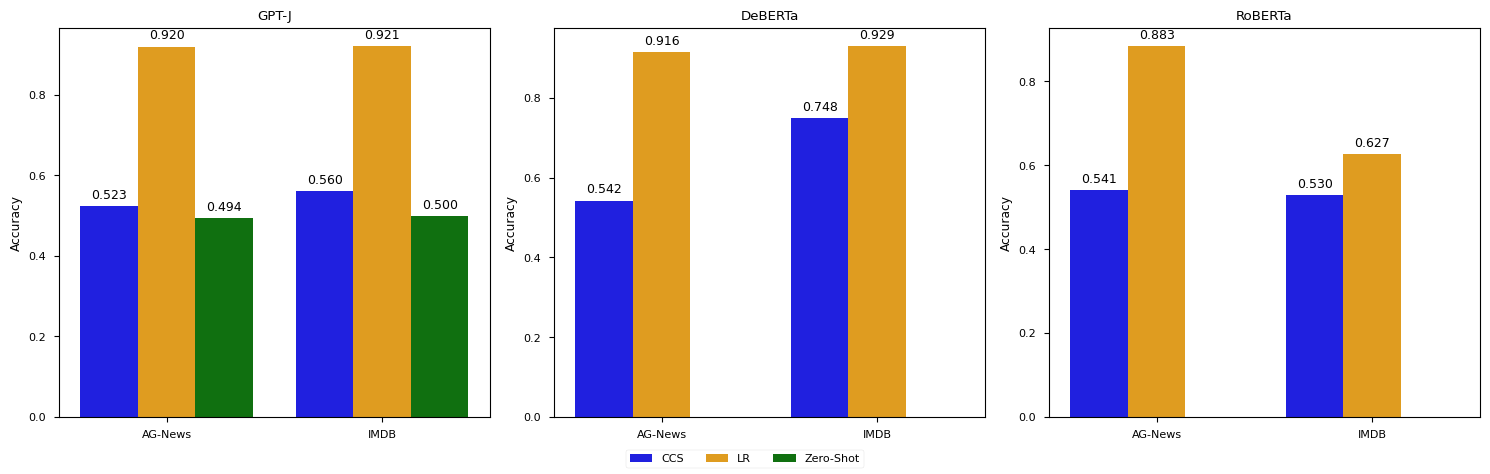

Ensembling: none


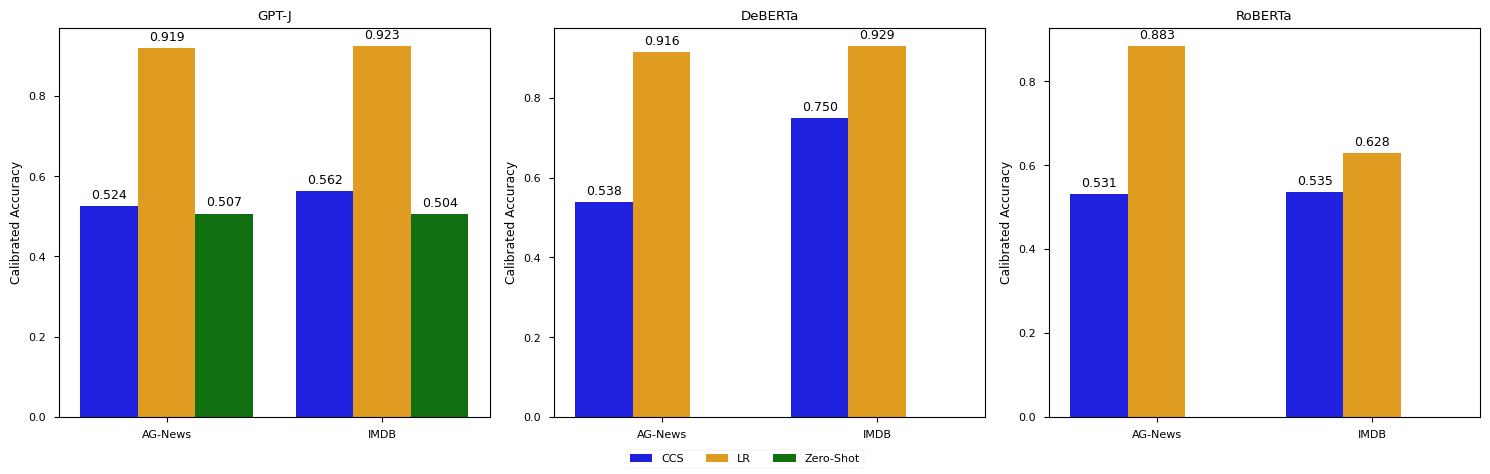

Ensembling: none


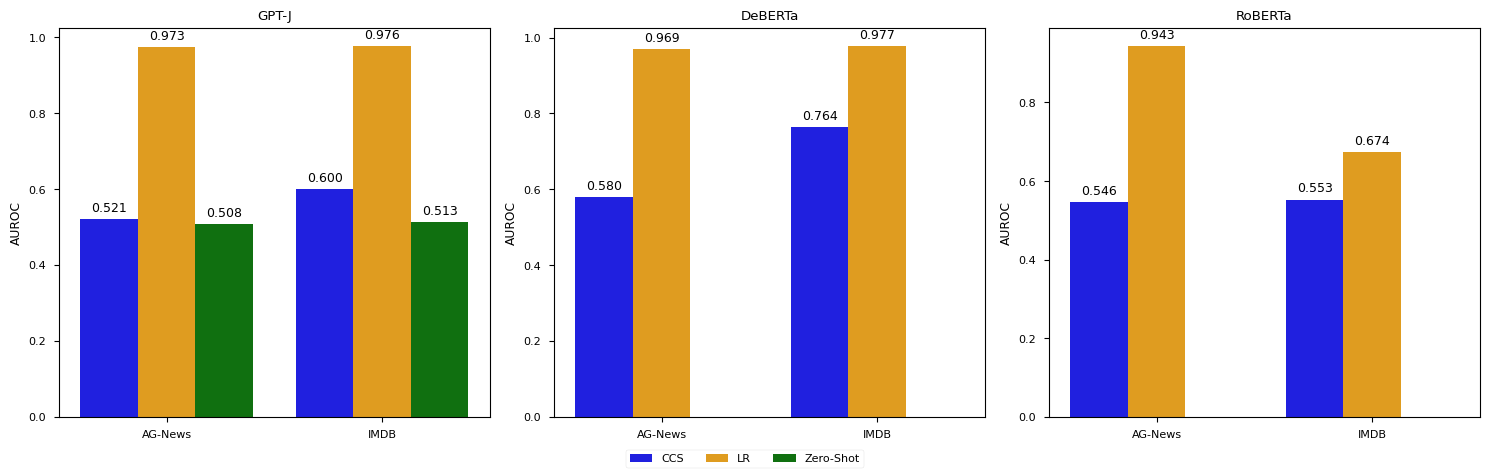

Ensembling: none


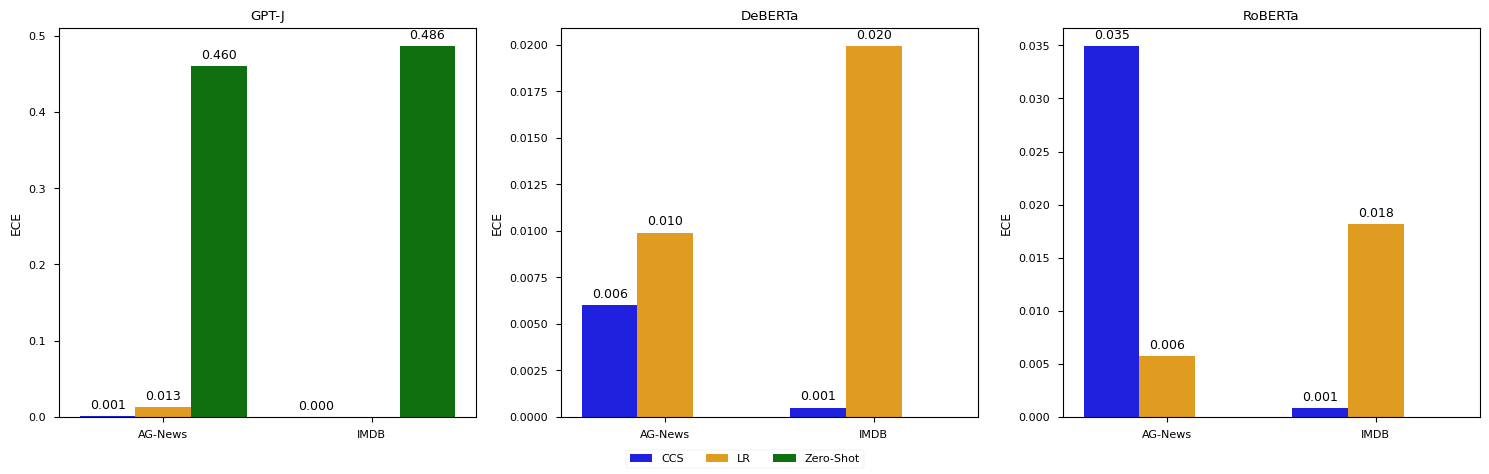

Ensembling: burns


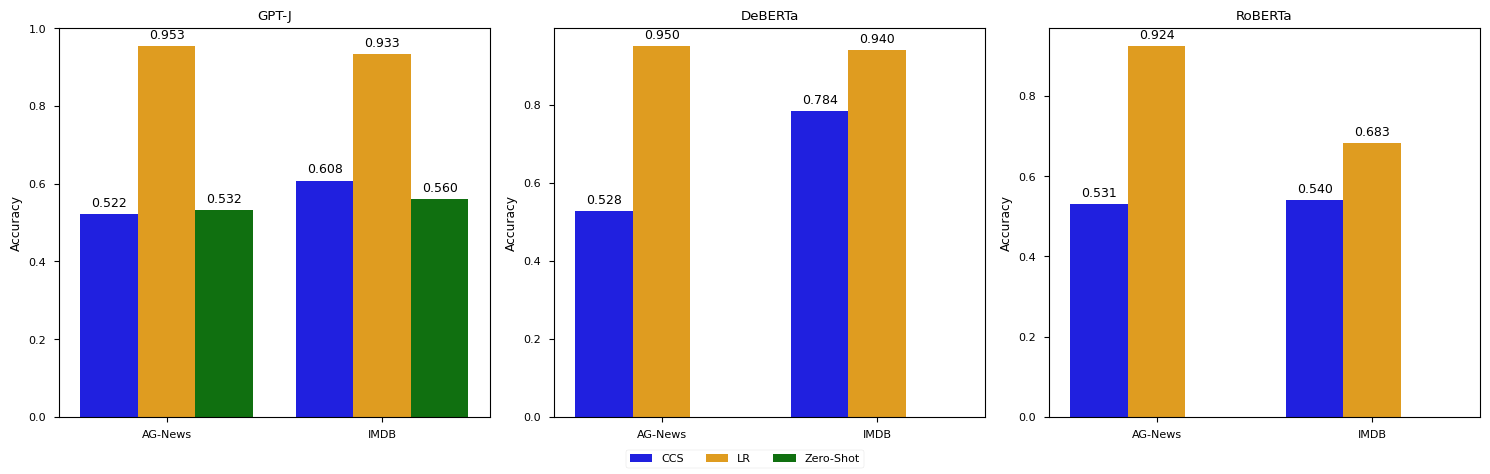

Ensembling: burns


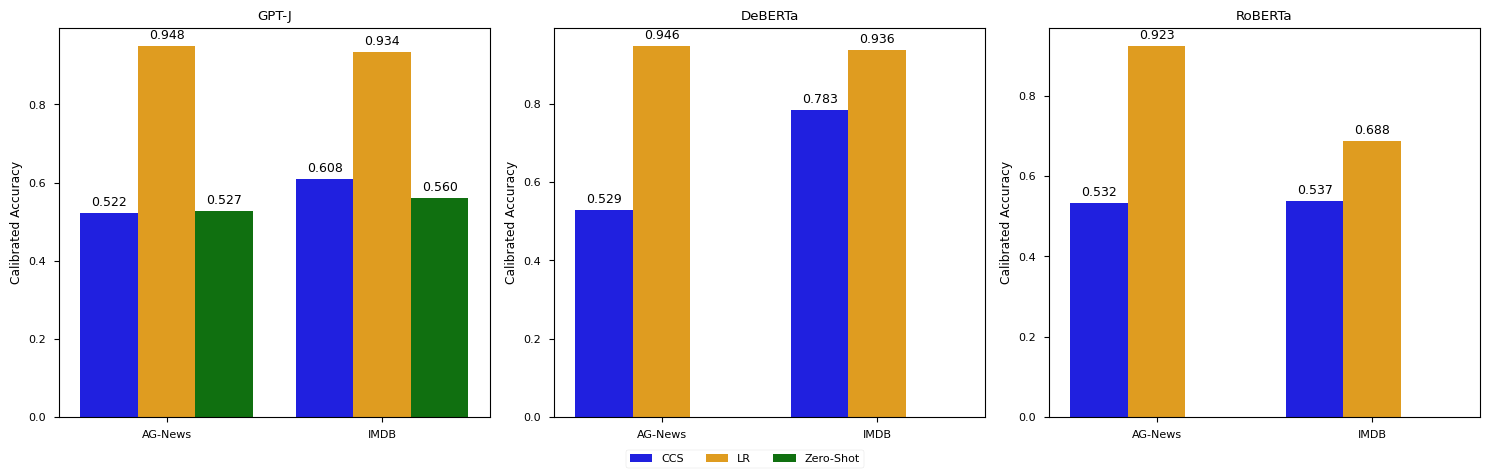

Ensembling: burns


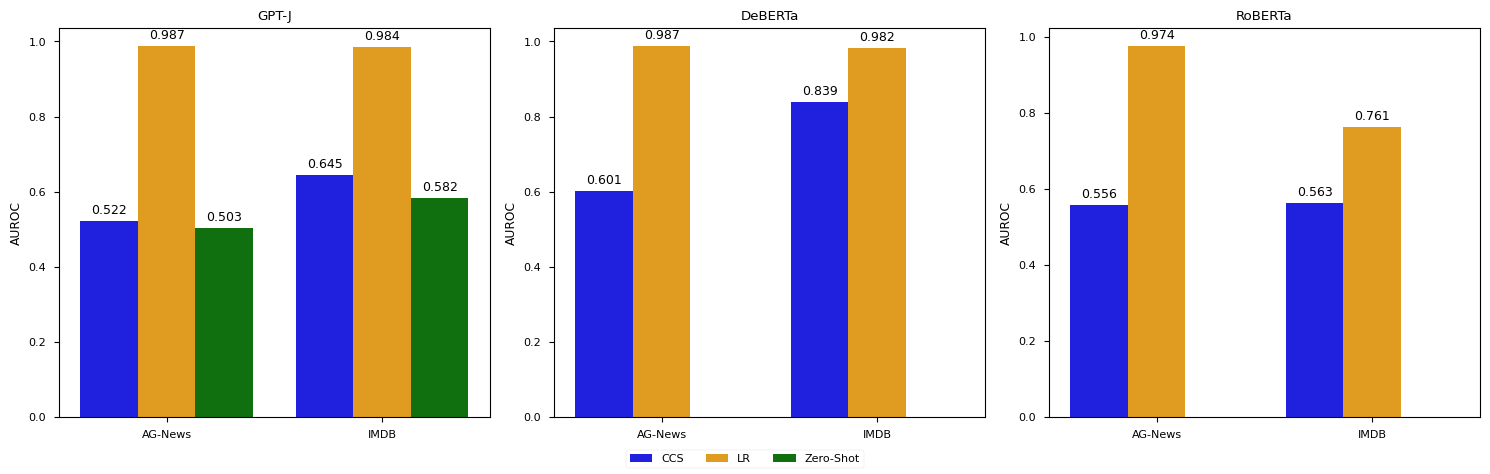

Ensembling: burns


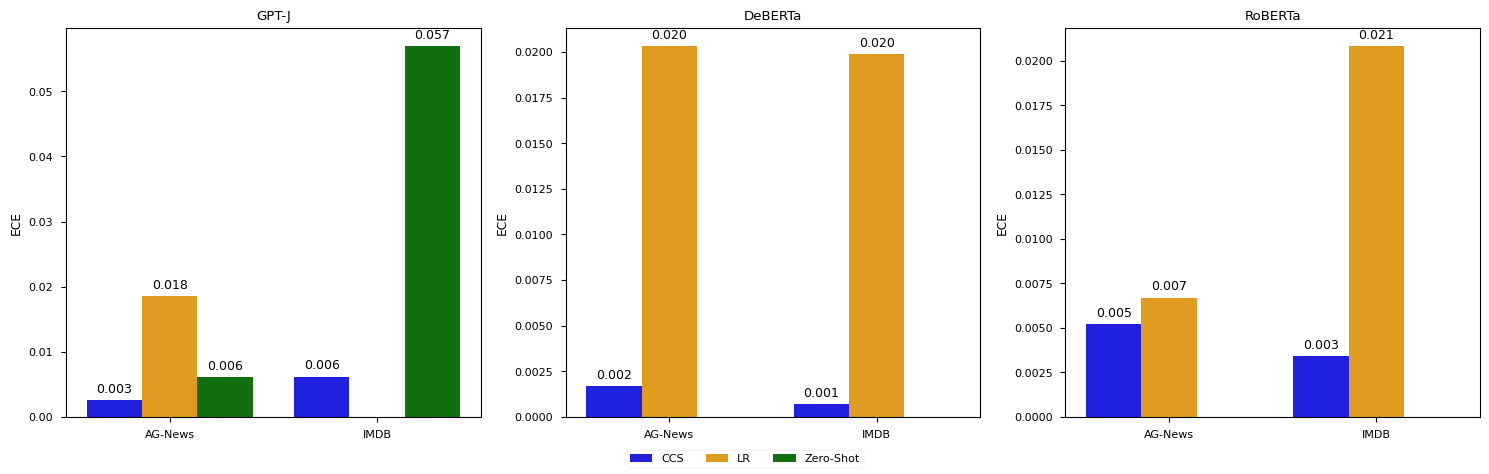

Ensembling: partial


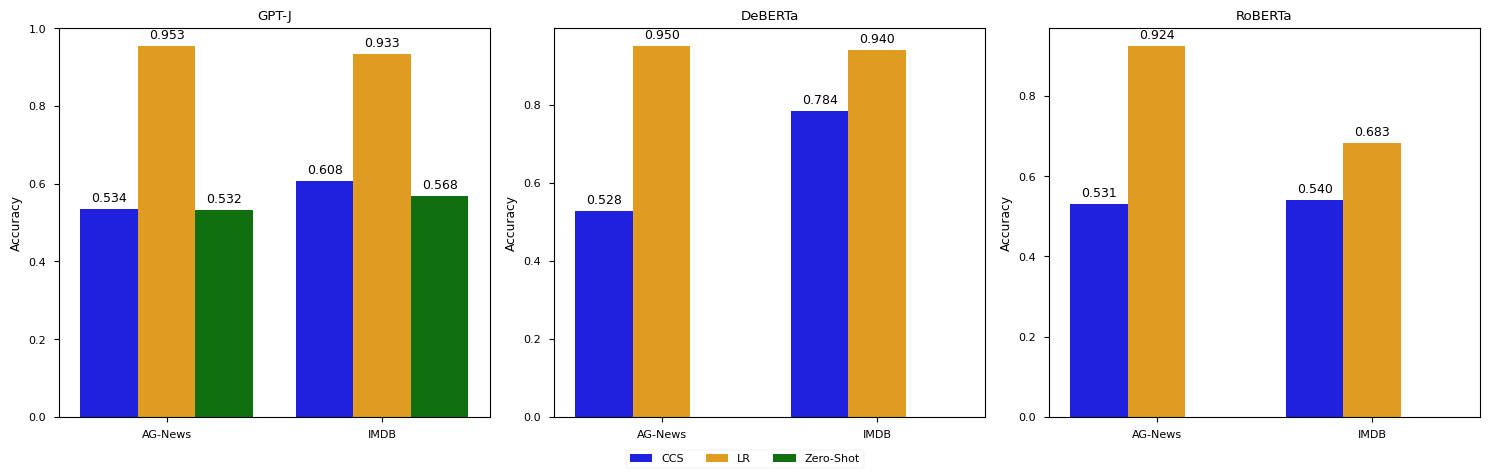

Ensembling: partial


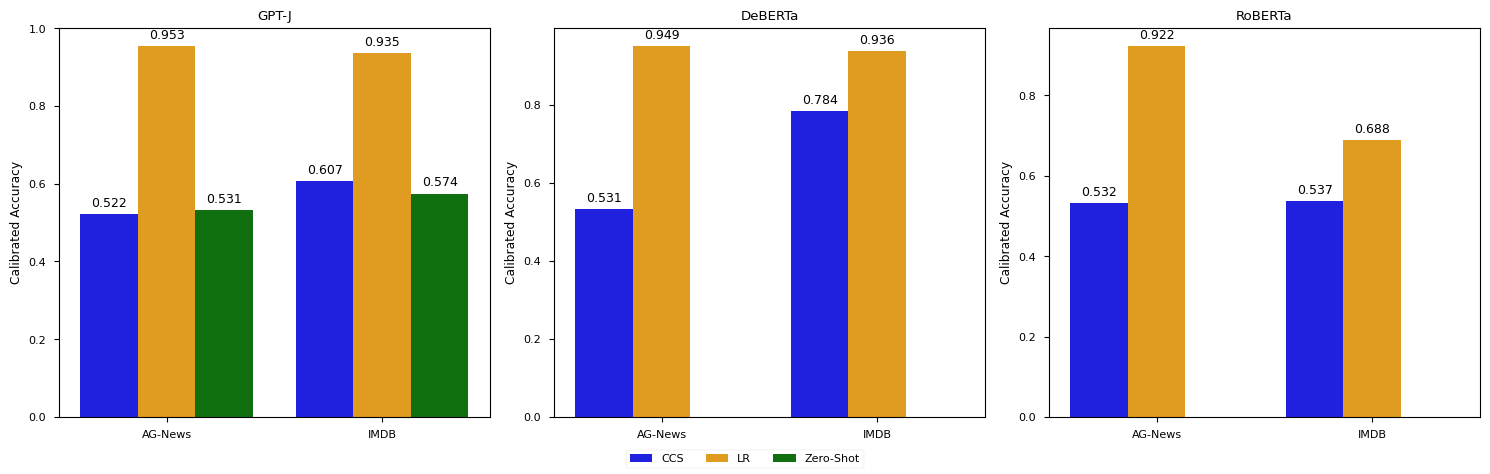

Ensembling: partial


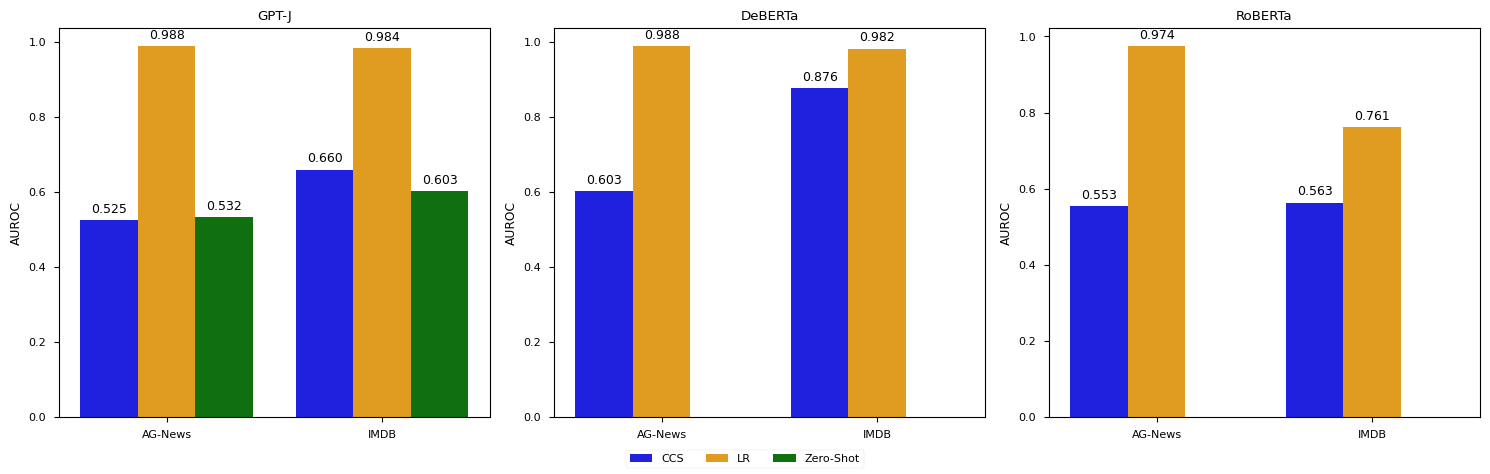

Ensembling: partial


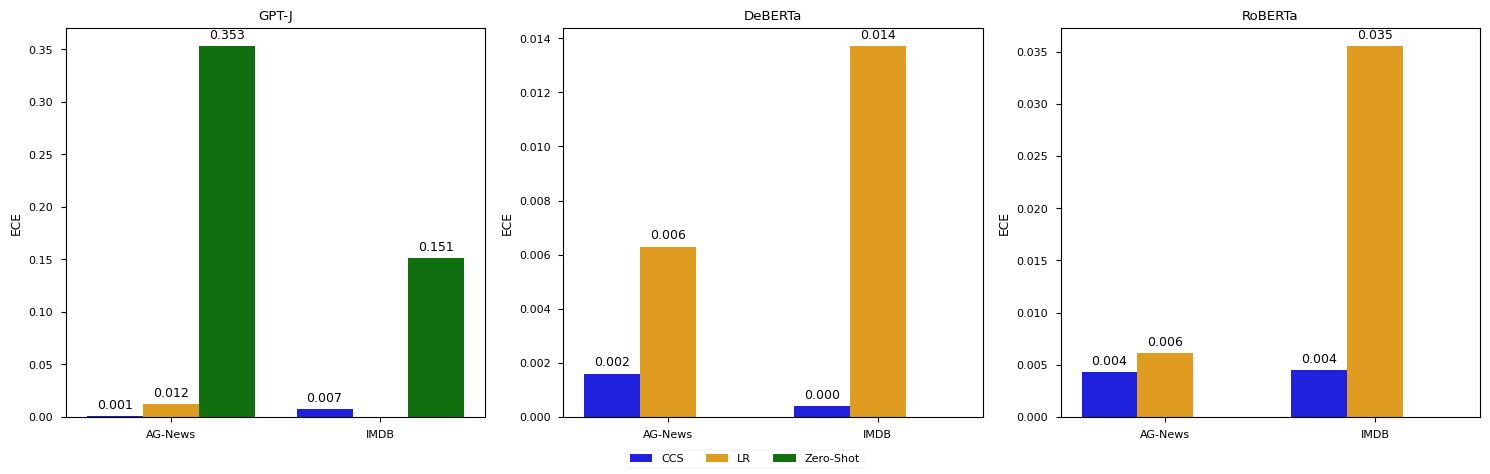

Ensembling: full


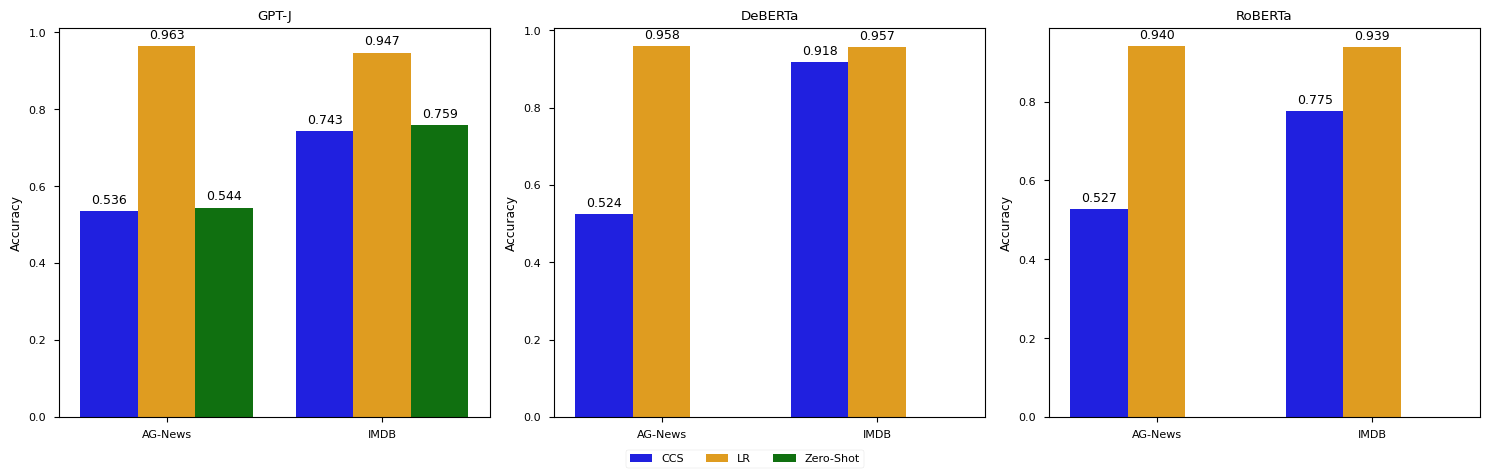

Ensembling: full


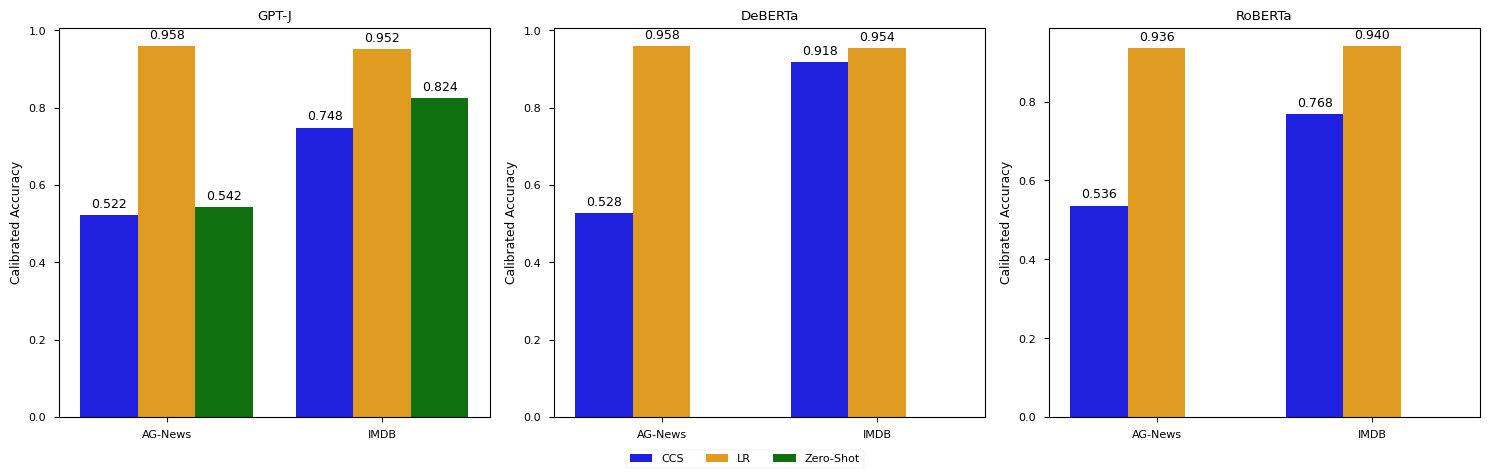

Ensembling: full


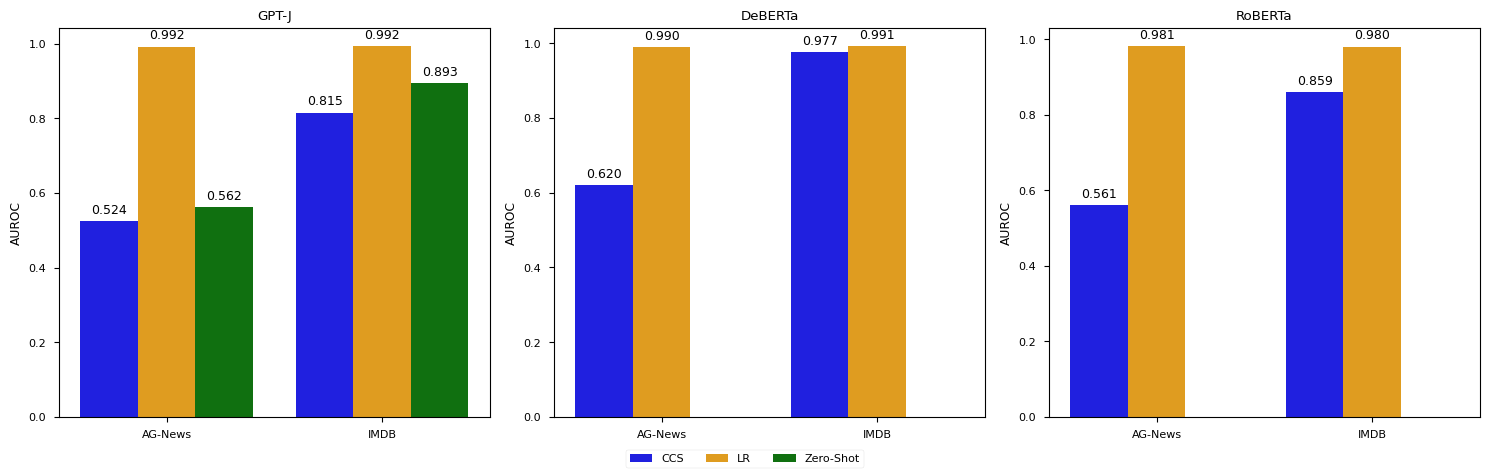

Ensembling: full


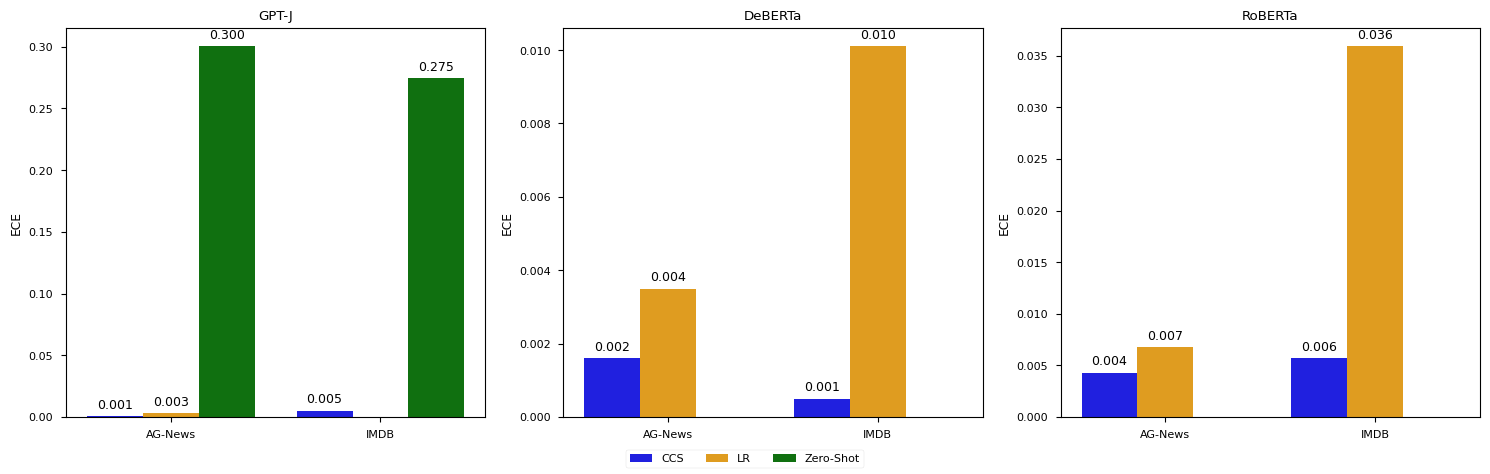

In [101]:
for ensembling in ENSEMBLING_MODES:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        plot_grouped_accuracy_by_model_with_labels(
            results_df_without_transfer,
            layer=None,
            ensembling=ensembling,
            metric=metric,
        )

# Metric per model, avg over datasets

In [102]:
def plot_mean_metric_by_model_with_labels(
    df, layer=None, ensembling=None, metric: str = "acc_estimate"
):
    """
    Creates a figure showing grouped bar plots of the average metric of CCS, LR,
    and Zero-Shot averaged over all the datasets, with labels on top of each bar.

    Args:
        df (pd.DataFrame): DataFrame with experiment results.
        metric: "acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece".
    """
    metric_options = [
        "acc_estimate",
        "cal_acc_estimate",
        "auroc_estimate",
        "ece",
    ]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")

    metric_cols = [
        f"{method}_{metric}" for method in ["eval", "lr_eval", "lm_eval"]
    ]
    method_mapping = {
        k: v for k, v in zip(metric_cols, ["CCS", "LR", "Zero-Shot"])
    }

    # Filter relevant columns
    df = df[
        [
            "model",
            "dataset",
            *metric_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    # Group by model and dataset, and get the best metric results.
    grouped_df = get_best_metric_per_model_and_dataset(
        df, metric, layer=layer, ensembling=ensembling
    )
    # Average over datasets.
    grouped_df = grouped_df.groupby(["model"]).mean(numeric_only=True)
    # If there is only one model, grouped_df is a single row as a pd.Series. Conver it to a
    # one-row DataFrame.
    if isinstance(grouped_df, pd.Series):
        grouped_df = pd.DataFrame([grouped_df])

    grouped_df = grouped_df.reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create subplots
    fig, ax = plt.subplots(
        1, 1, figsize=(3 * len(models), 5), sharex=True, squeeze=True
    )

    # Create a color palette
    palette = ["blue", "orange", "green"]

    # Melt the DataFrame for easy plotting
    melted_df = grouped_df.melt(
        id_vars=["model"],
        value_vars=metric_cols,
        var_name="method",
        value_name="metric",
    )

    # Map methods and models to more readable names
    melted_df["method"] = melted_df["method"].map(method_mapping)
    melted_df["model"] = melted_df["model"].map(
        lambda x: MODEL_TO_LABEL.get(x, x)
    )

    # Plot grouped bar plot
    bars = sns.barplot(
        data=melted_df,
        x="model",
        y="metric",
        hue="method",
        palette=palette,
        ax=ax,
    )

    # Add text labels on top of each bar
    for bar in bars.patches:
        # Skip bars with height 0 to avoid showing "0.00" label
        if bar.get_height() > 0:
            bars.annotate(
                format(bar.get_height(), ".3f"),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="center",
                size=9,
                xytext=(0, 8),
                textcoords="offset points",
            )

    ax.set_ylabel(METRIC_TO_LABEL[metric])
    ax.set_xlabel("")

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)
    ax.get_legend().remove()  # Remove the legend on the plot

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

Ensembling: none


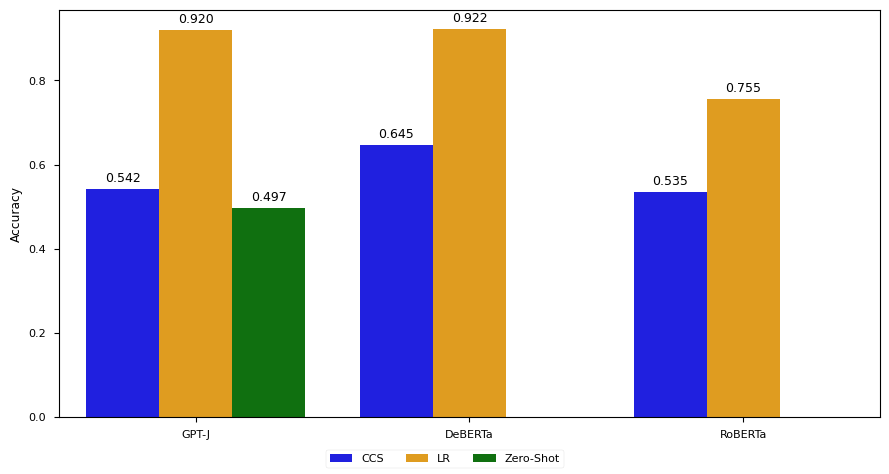

Ensembling: none


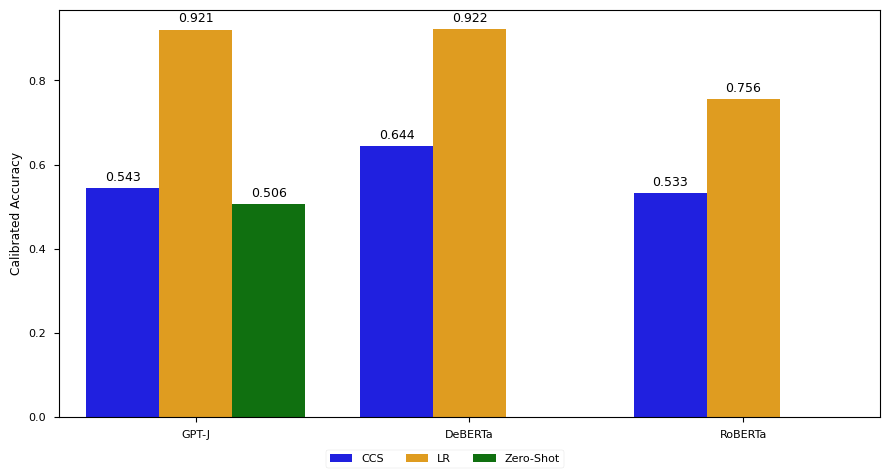

Ensembling: none


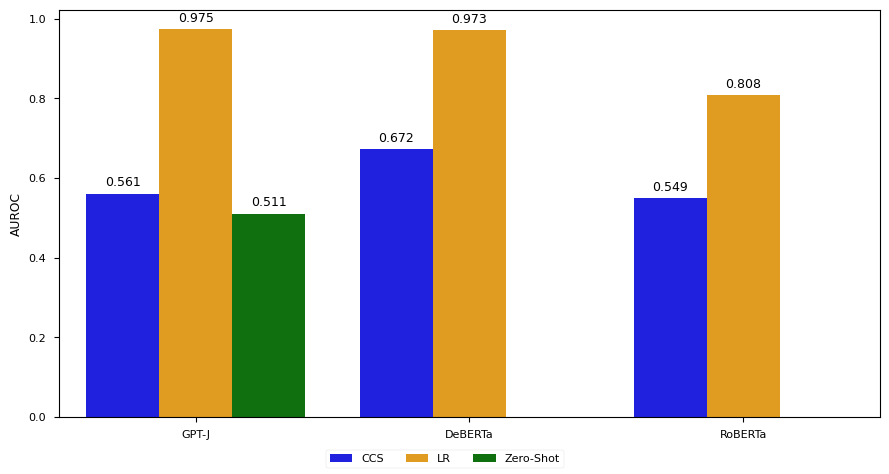

Ensembling: none


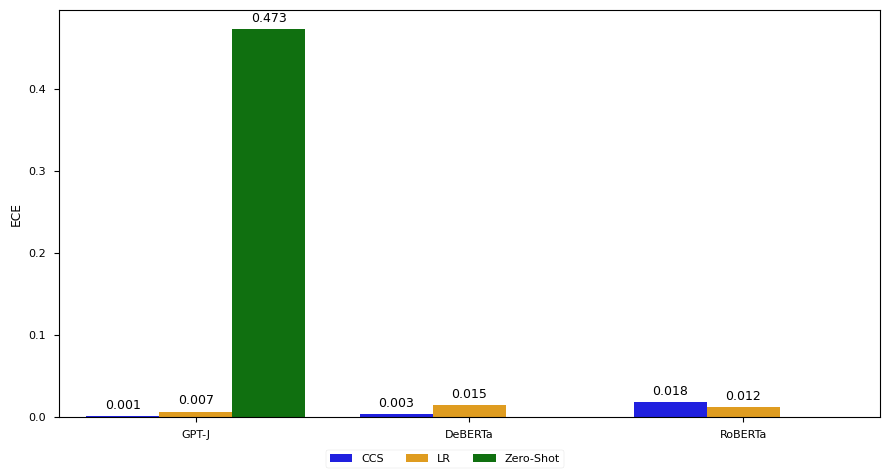

Ensembling: burns


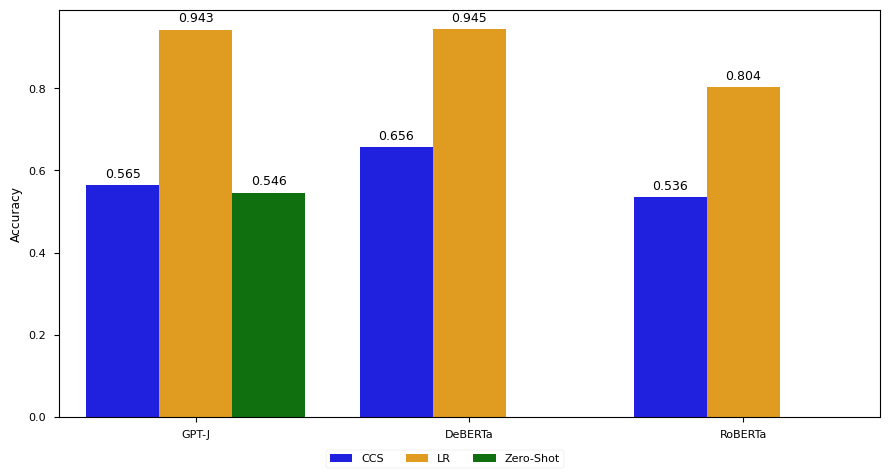

Ensembling: burns


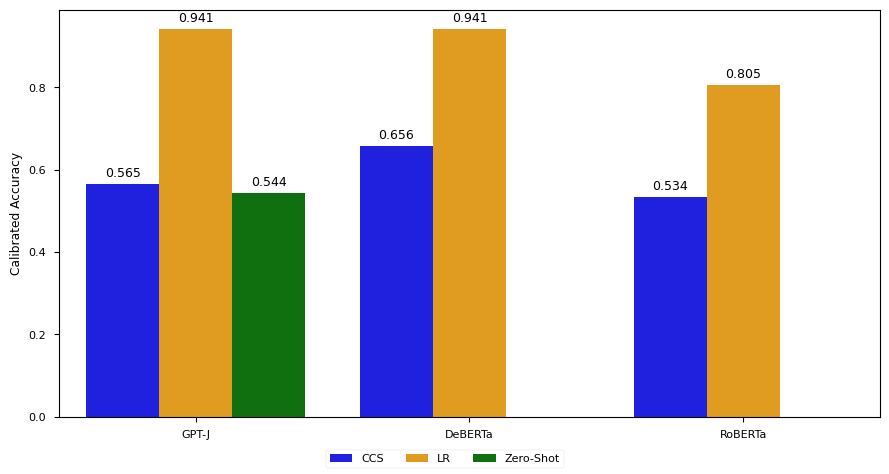

Ensembling: burns


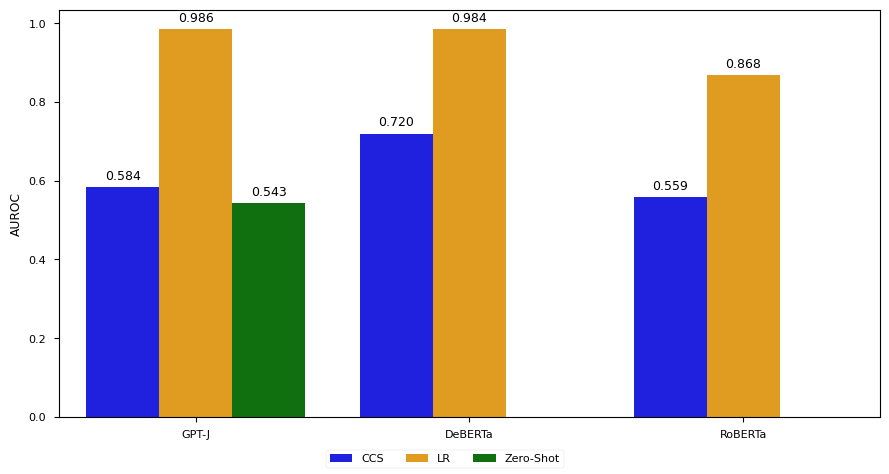

Ensembling: burns


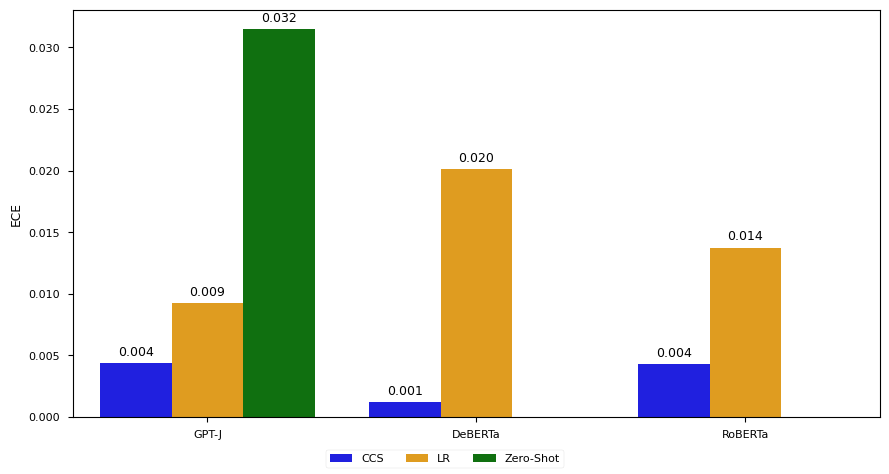

Ensembling: partial


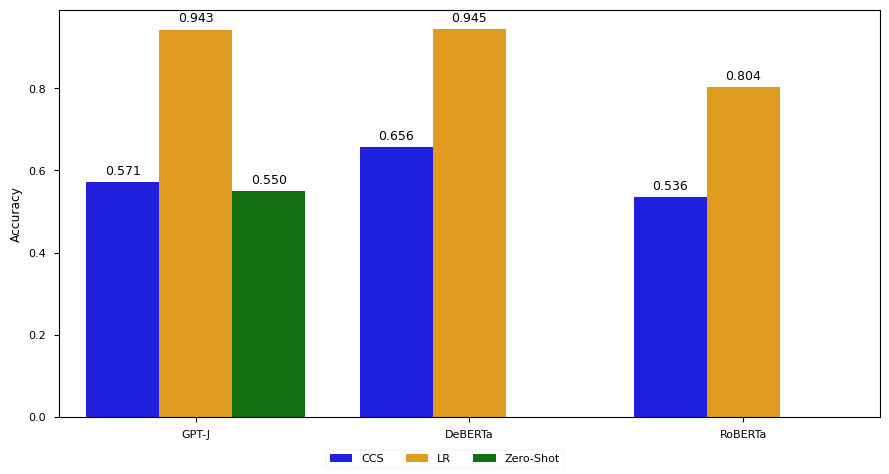

Ensembling: partial


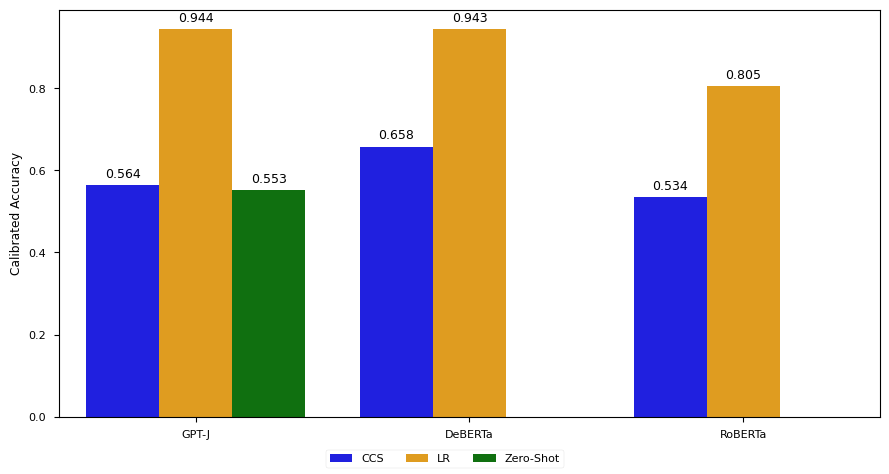

Ensembling: partial


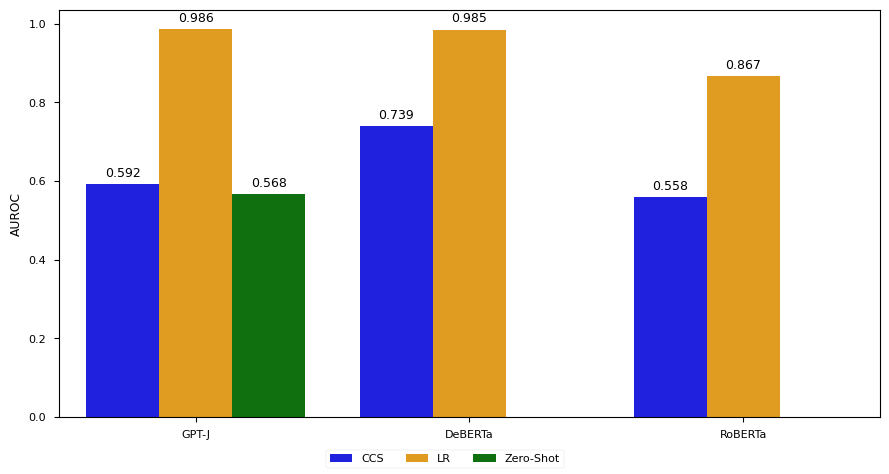

Ensembling: partial


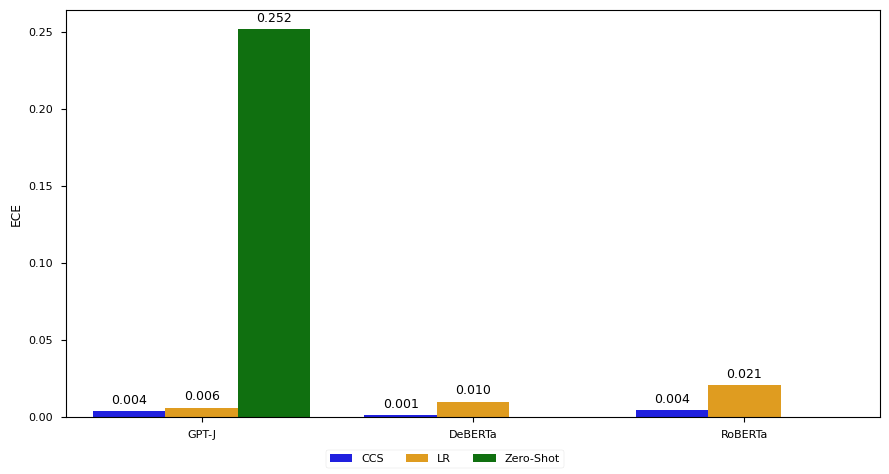

Ensembling: full


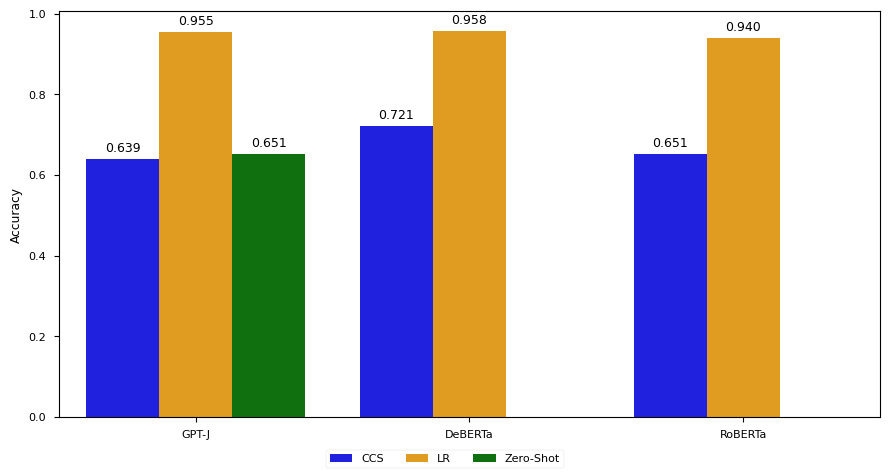

Ensembling: full


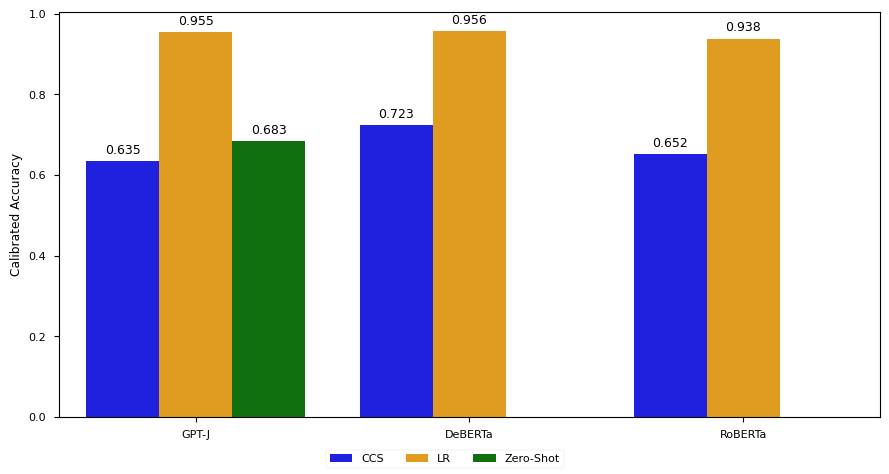

Ensembling: full


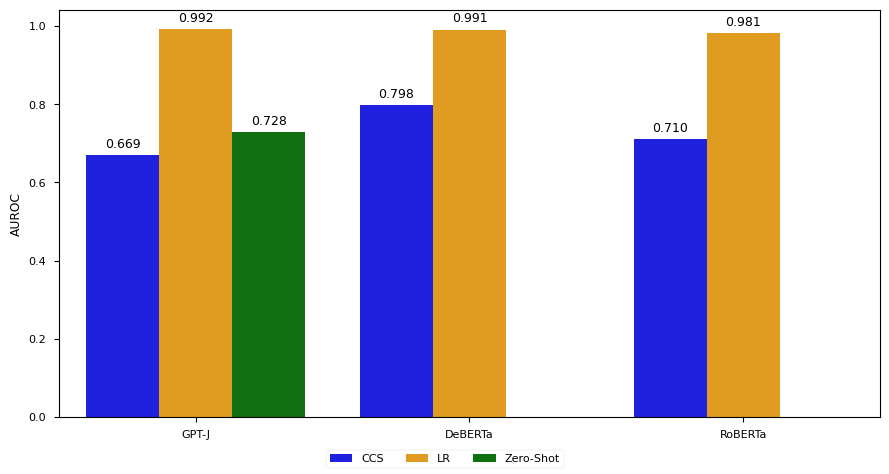

Ensembling: full


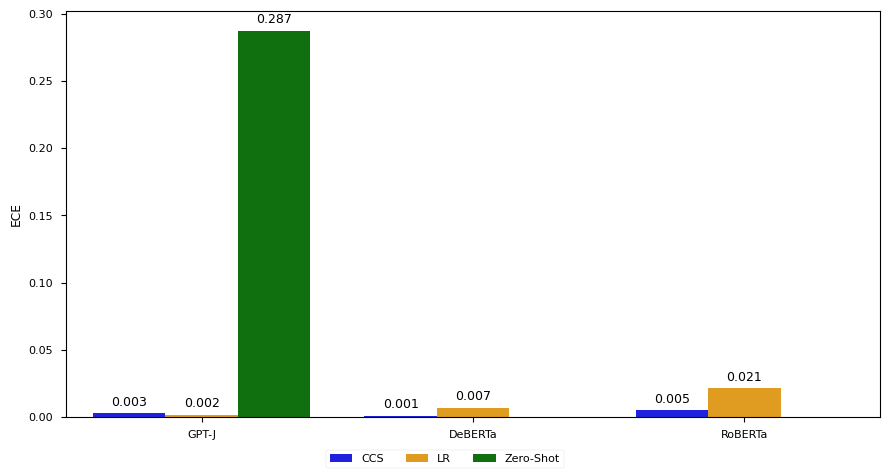

In [103]:
for ensembling in ENSEMBLING_MODES:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        plot_mean_metric_by_model_with_labels(
            results_df_without_transfer,
            layer=None,
            ensembling=ensembling,
            metric=metric,
        )

# Metric vs. layer

In [104]:
def plot_metric_vs_layer(results_df, ensembling=None, metric="auroc_estimate"):
    metric_options = [
        "acc_estimate",
        "cal_acc_estimate",
        "auroc_estimate",
        "ece",
    ]
    if metric not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")

    metric_cols = [
        f"{method}_{metric}" for method in ["eval", "lr_eval", "lm_eval"]
    ]
    method_mapping = {
        k: v for k, v in zip(metric_cols, ["CCS", "LR", "Zero-Shot"])
    }

    # Filter relevant columns
    df = results_df[
        [
            "model",
            "dataset",
            *metric_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]

    # Group by model and dataset, take the min/max, then average over the datasets.
    grouped_df = df.groupby(["model", "dataset", "eval_layer"])
    grouped_df = grouped_df.min() if metric == "ece" else grouped_df.max()
    grouped_df = grouped_df.groupby(["model", "eval_layer"]).mean(
        numeric_only=True
    )
    # If there is only one model, grouped_df is a single row as a pd.Series. Conver it to a
    # one-row DataFrame.
    if isinstance(grouped_df, pd.Series):
        grouped_df = pd.DataFrame([grouped_df])

    grouped_df = grouped_df.reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create a color palette (one color per method - CCS, LR, Zero-Shot)
    palette = ["blue", "orange", "green"]

    # Create subplots
    fig, axes = plt.subplots(
        1, len(models), figsize=(3 * len(models), 5), sharex=False, sharey=True
    )

    if len(models) == 1:
        axes = [axes]  # Ensure axes is always a list

    for ax, model in zip(axes, models):
        # Filter data for this model
        model_df = grouped_df[grouped_df["model"] == model]

        # Melt the DataFrame for easy plotting
        melted_df = model_df.melt(
            id_vars=["model", "eval_layer"],
            value_vars=metric_cols,
            var_name="method",
            value_name="metric",
        )

        # Map methods to more readable names
        melted_df["method"] = melted_df["method"].map(method_mapping)

        # Plot line plot
        bars = sns.lineplot(
            data=melted_df,
            x="eval_layer",
            y="metric",
            hue="method",
            palette=palette,
            ax=ax,
        )

        ax.set_title(MODEL_TO_LABEL[model])
        ax.set_ylabel(METRIC_TO_LABEL[metric])
        ax.set_xlabel("Layer")

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)
    for ax in axes:
        ax.get_legend().remove()

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

Ensembling: none


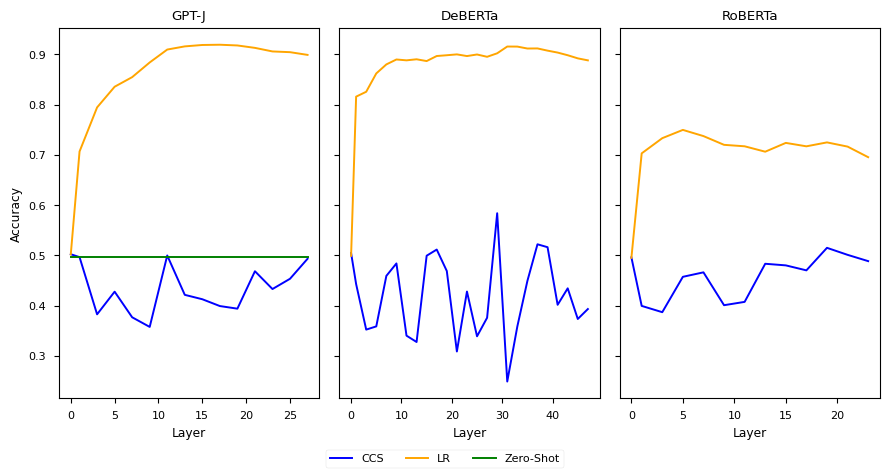

Ensembling: none


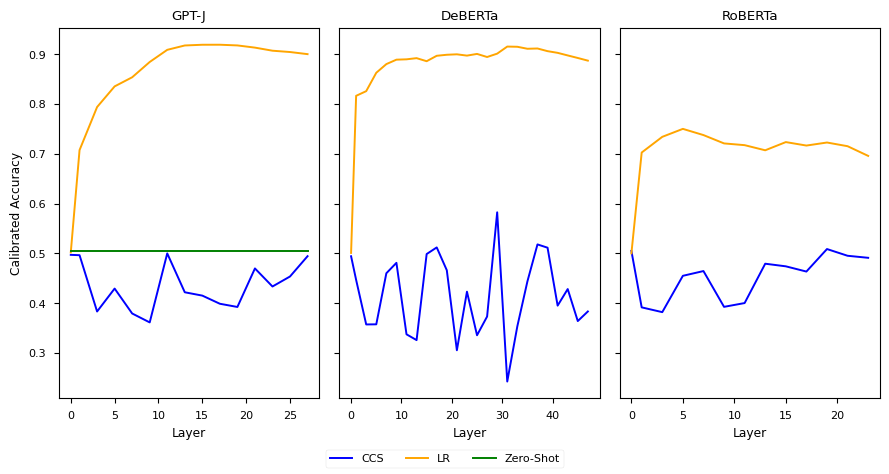

Ensembling: none


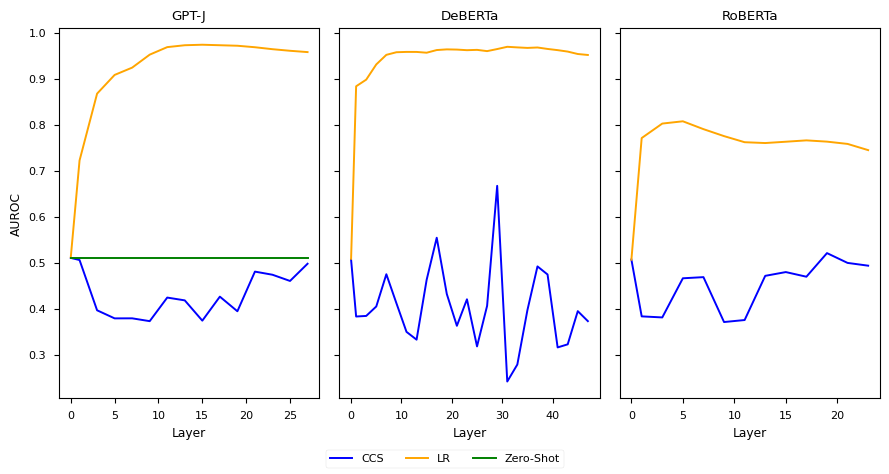

Ensembling: none


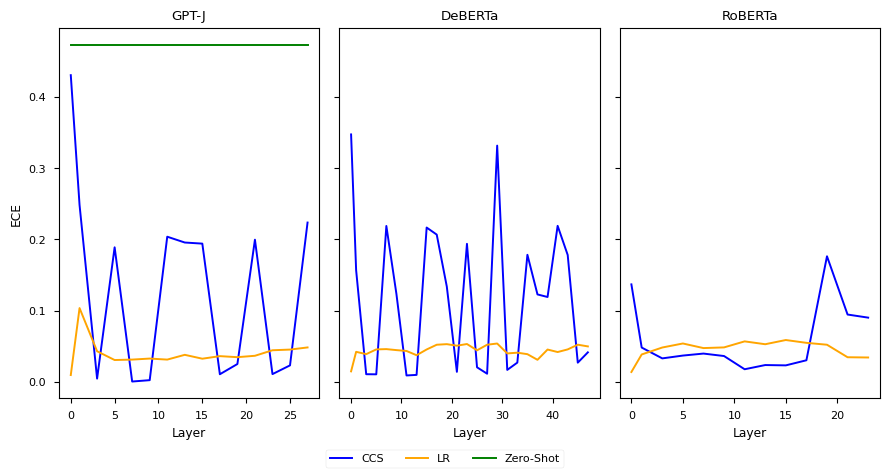

Ensembling: burns


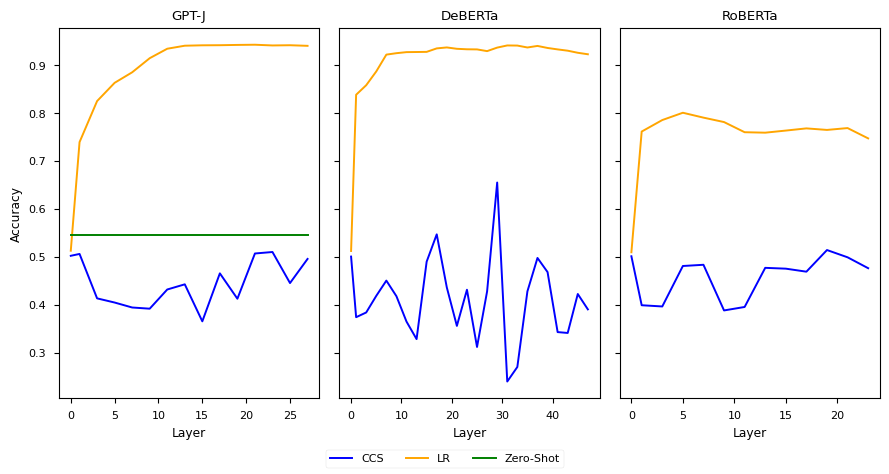

Ensembling: burns


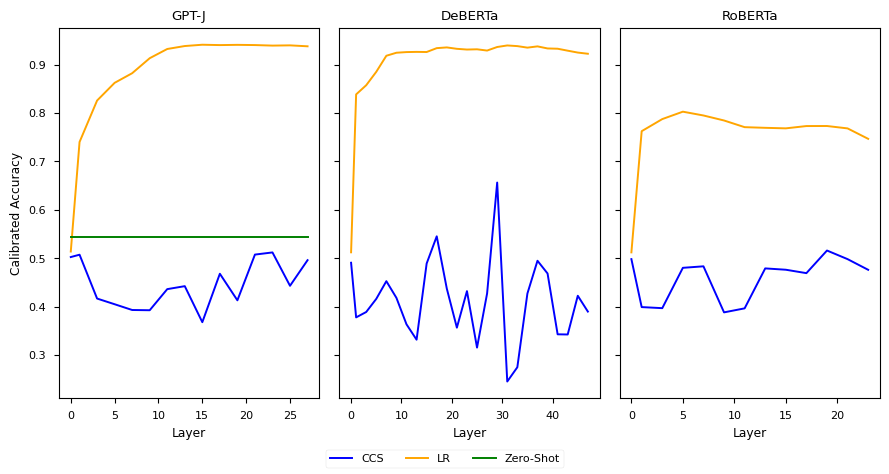

Ensembling: burns


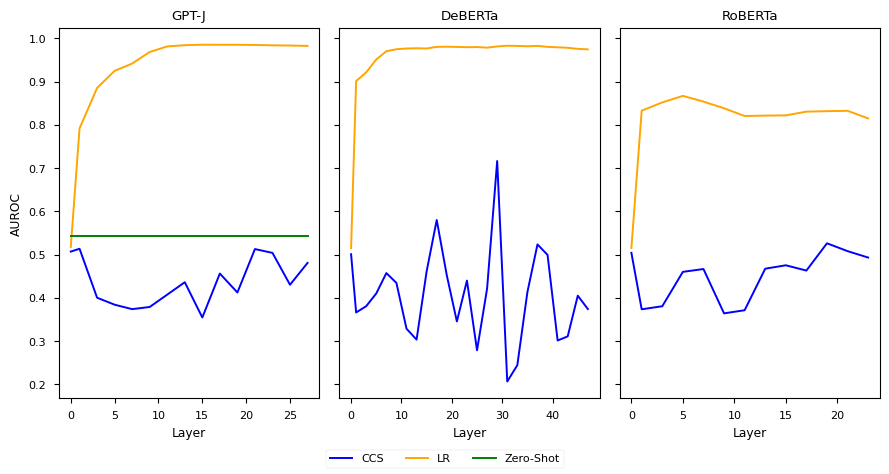

Ensembling: burns


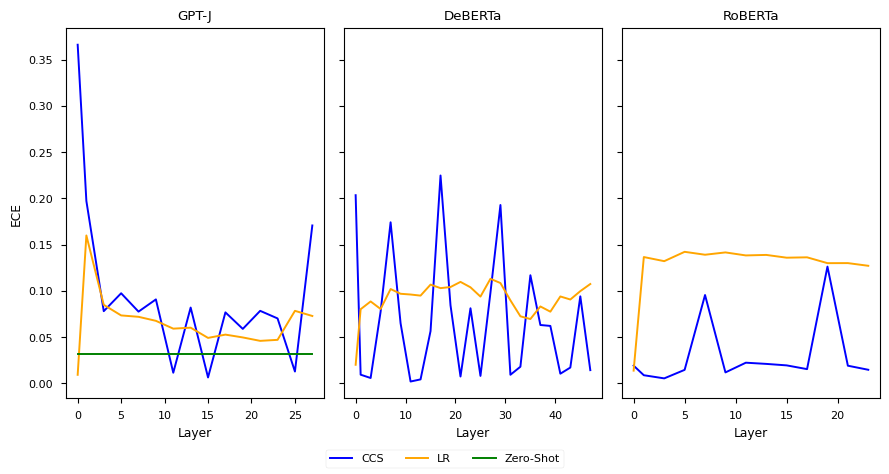

Ensembling: partial


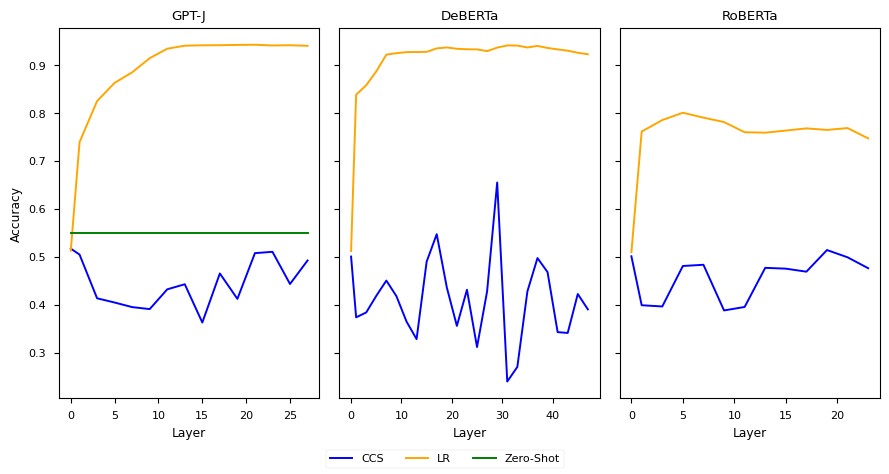

Ensembling: partial


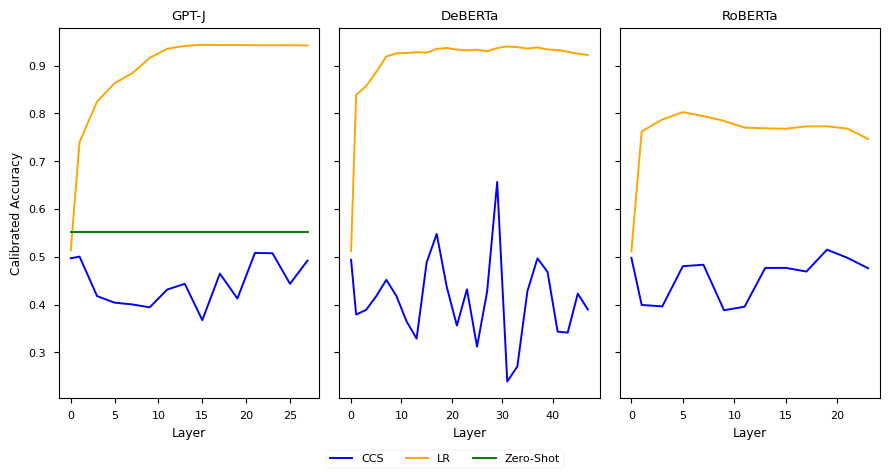

Ensembling: partial


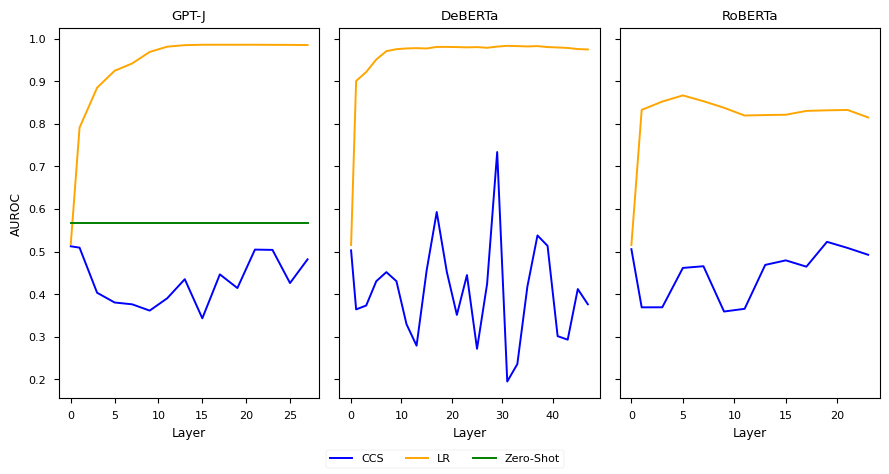

Ensembling: partial


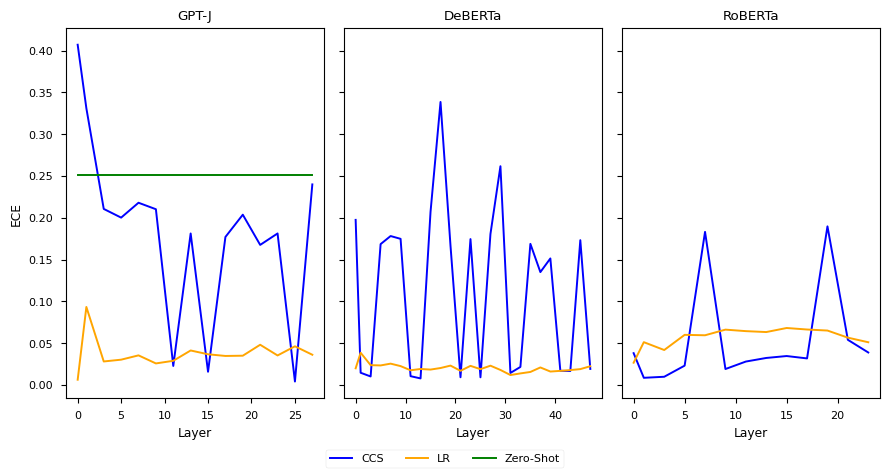

Ensembling: full


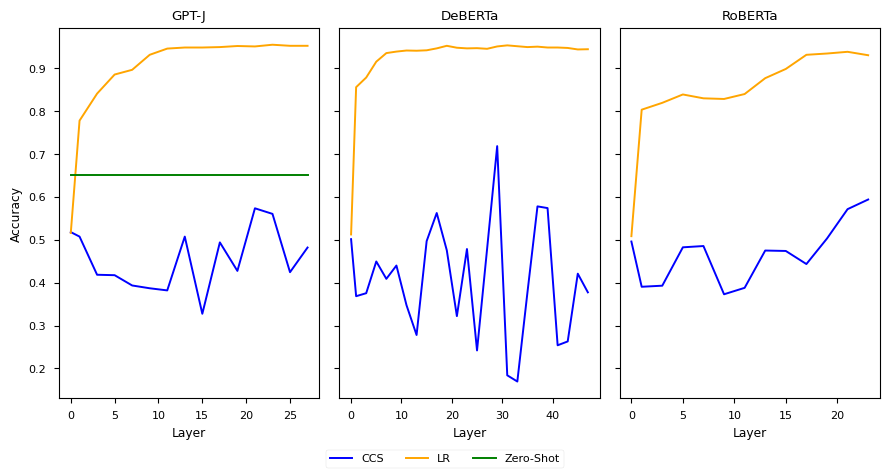

Ensembling: full


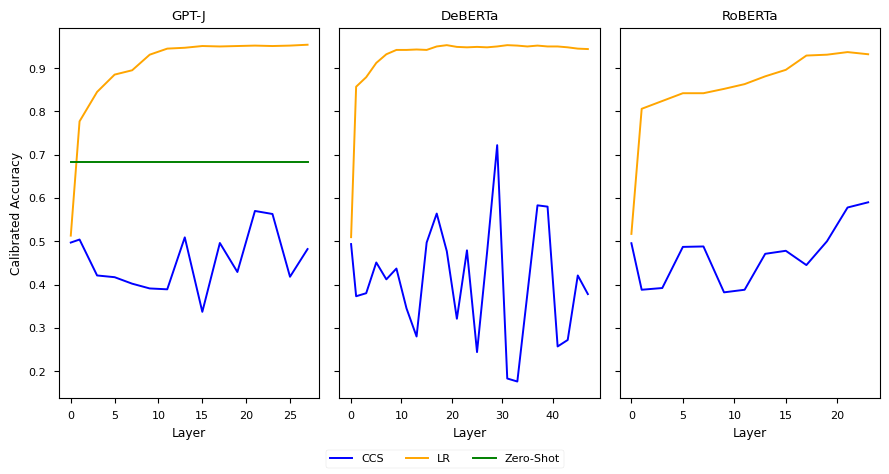

Ensembling: full


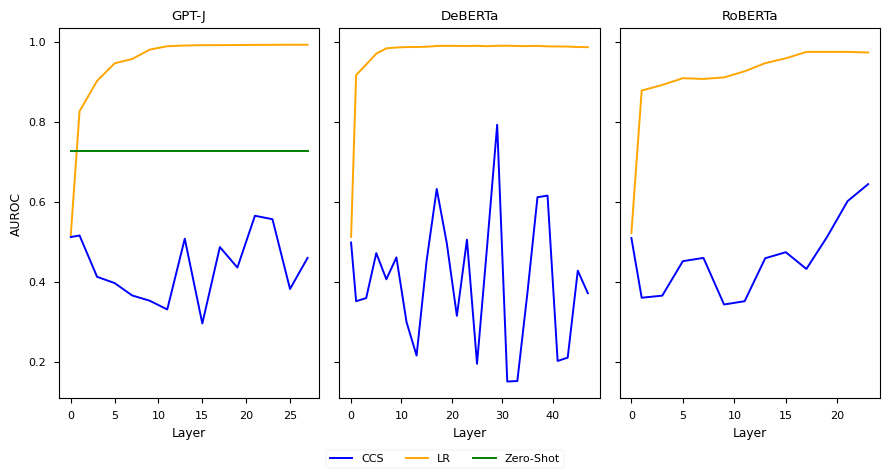

Ensembling: full


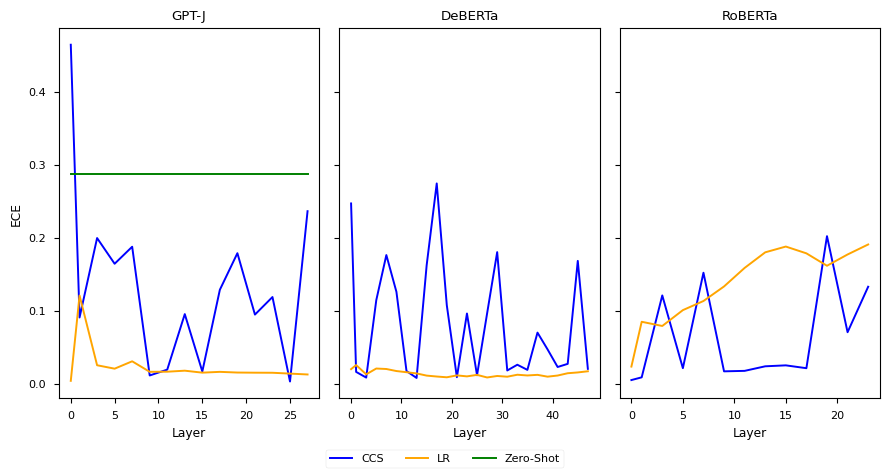

In [105]:
for ensembling in ENSEMBLING_MODES:
    for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
        print(f"Ensembling: {ensembling}")
        plot_metric_vs_layer(
            results_df_without_transfer, ensembling=ensembling, metric=metric
        )

# Transfer heatmaps

In [106]:
def generate_heatmaps(df, metric_name: str, layer=None, ensembling=None):
    # Validate metric name
    metric_options = [
        "acc_estimate",
        "cal_acc_estimate",
        "auroc_estimate",
        "ece",
    ]
    if metric_name not in metric_options:
        raise ValueError(f"Invalid metric. Must be one of {metric_options}")
    # If layer is specified, filter by layer
    if layer is not None:
        df = df[
            (df["eval_layer"] == layer)
            & (df["lr_eval_layer"] == layer)
            & (df["lm_eval_layer"] == layer)
        ]
    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]
    # Group by model, training dataset, and eval dataset.
    grouped_df = df.groupby(["model", "dataset", "eval_dataset"])
    # Take the min if ECE, max if accuracy or AUROC.
    grouped_df = grouped_df.min() if metric_name == "ece" else grouped_df.max()
    grouped_df = grouped_df.reset_index()

    # Define CCS and LR column suffixes
    ccs_suffix = f"eval_{metric_name}"
    lr_suffix = f"lr_eval_{metric_name}"

    # Get unique models and datasets
    models = grouped_df["model"].unique()
    datasets = grouped_df["dataset"].unique()

    # Create figure with n rows and 2 columns
    fig, axes = plt.subplots(
        nrows=len(models), ncols=2, figsize=(10, 5 * len(models))
    )
    fig.suptitle(METRIC_TO_LABEL[metric_name], fontsize=16)

    for i, model in enumerate(models):
        for j, suffix in enumerate([ccs_suffix, lr_suffix]):
            # Filter dataframe for the current model
            model_df = grouped_df[grouped_df["model"] == model].copy()
            model_df["dataset"] = model_df["dataset"].map(
                lambda x: DATASET_TO_LABEL.get(x, x)
            )
            model_df["eval_dataset"] = model_df["eval_dataset"].map(
                lambda x: DATASET_TO_LABEL.get(x, x)
            )

            # Create pivot table for heatmap
            heatmap_data = model_df.pivot_table(
                index="dataset",
                columns="eval_dataset",
                values=suffix,
                aggfunc="mean",
            )
            # Sort by desired dataset order to match Burns et al.
            heatmap_data = heatmap_data.sort_values(
                by="dataset", key=get_dataset_order_series, axis=0
            ).sort_values(
                by="eval_dataset", key=get_dataset_order_series, axis=1
            )

            # Create heatmap
            ax = axes[i, j] if len(models) > 1 else axes[j]
            sns.heatmap(
                heatmap_data, annot=True, fmt=".3f", cmap="viridis", ax=ax
            )
            ax.set_title(
                f'{MODEL_TO_LABEL[model]} - {"CCS" if j == 0 else "LR"}'
            )
            ax.set_xlabel("Eval Dataset")
            ax.set_ylabel("Training Dataset")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

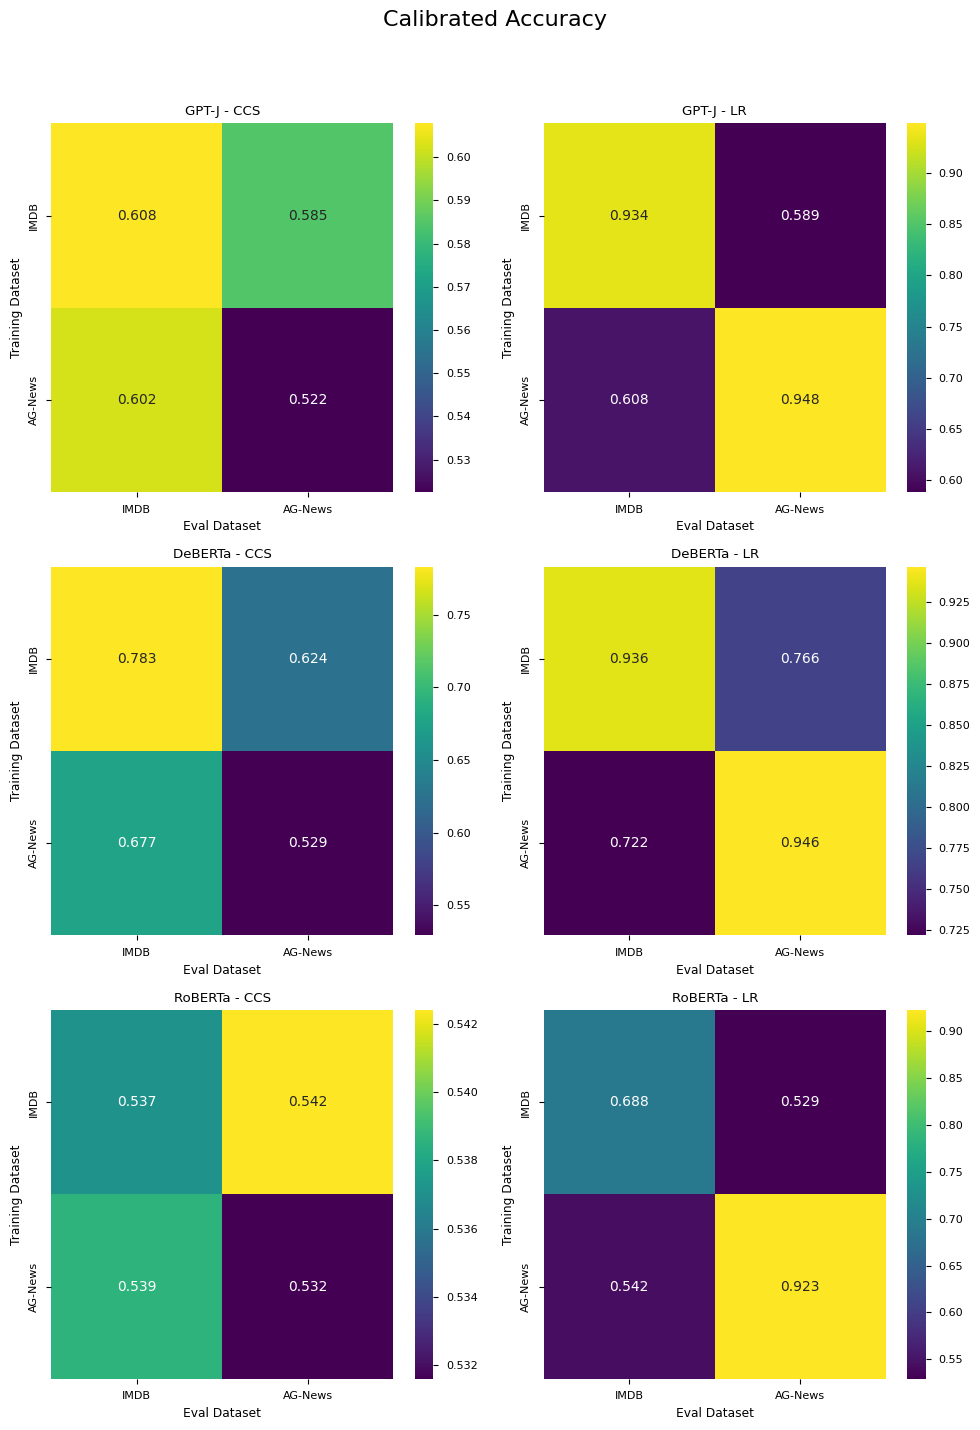

In [109]:
generate_heatmaps(results_df, "cal_acc_estimate", layer=None, ensembling="burns")

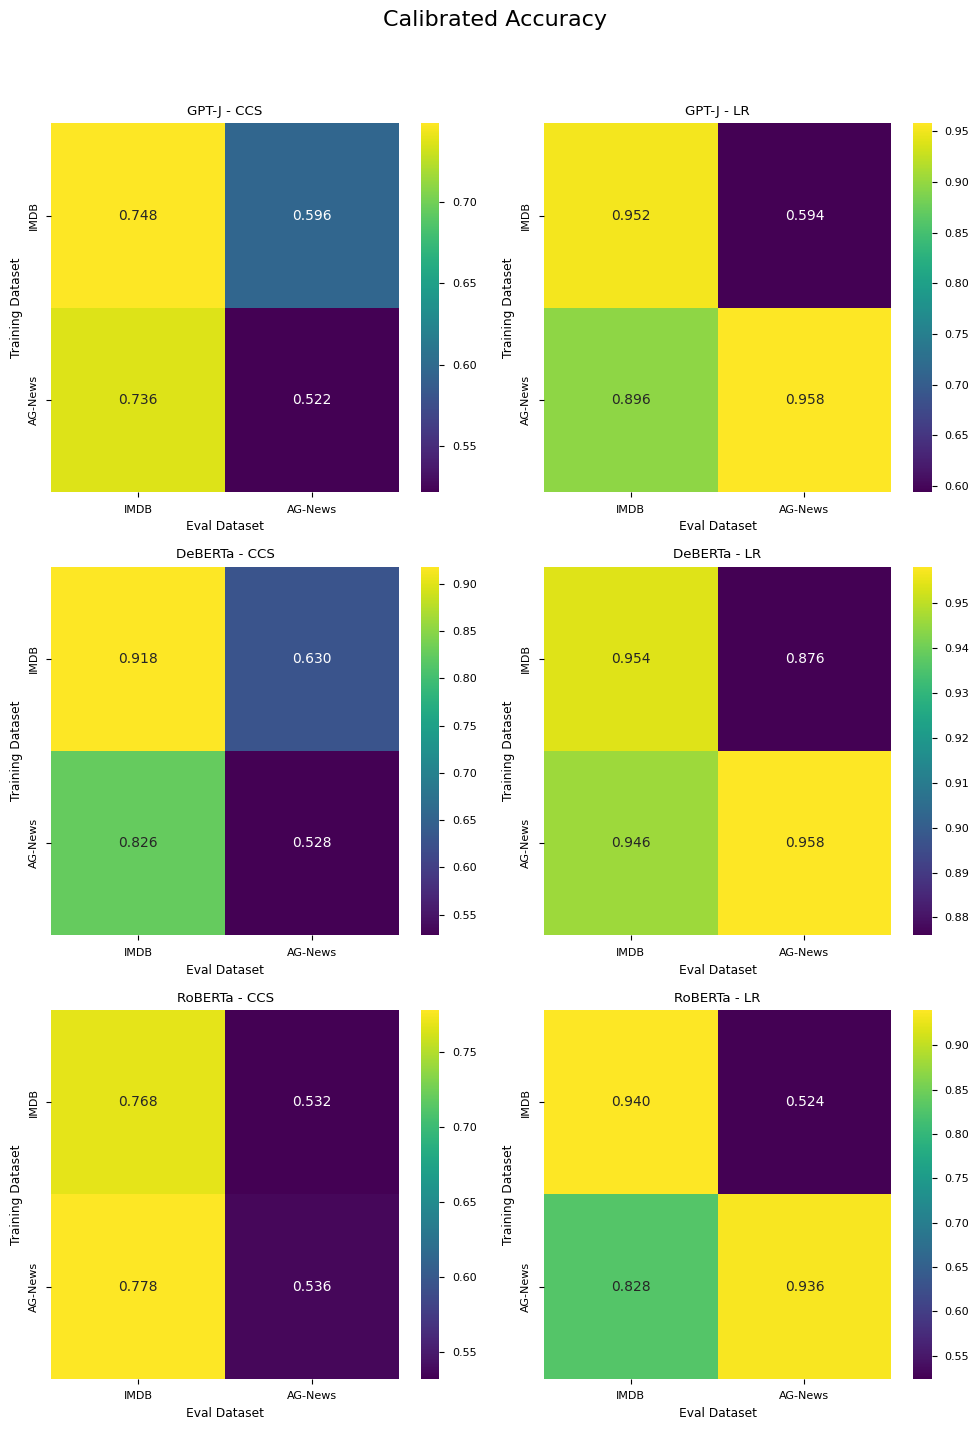

In [110]:
generate_heatmaps(results_df, "cal_acc_estimate", layer=None, ensembling="full")

Ensembling: burns


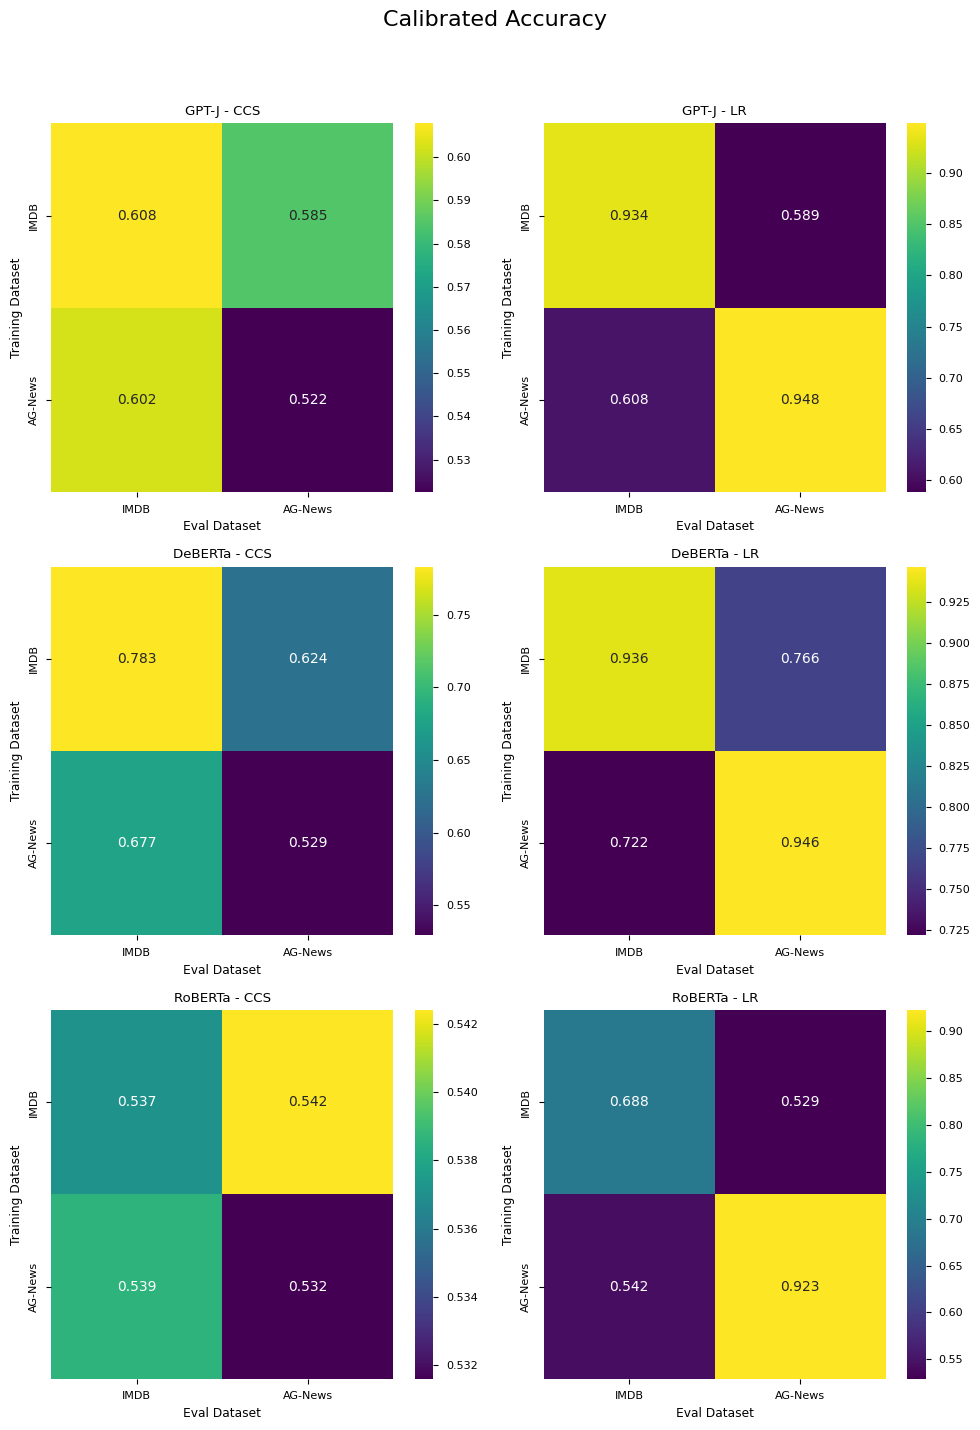

Ensembling: full


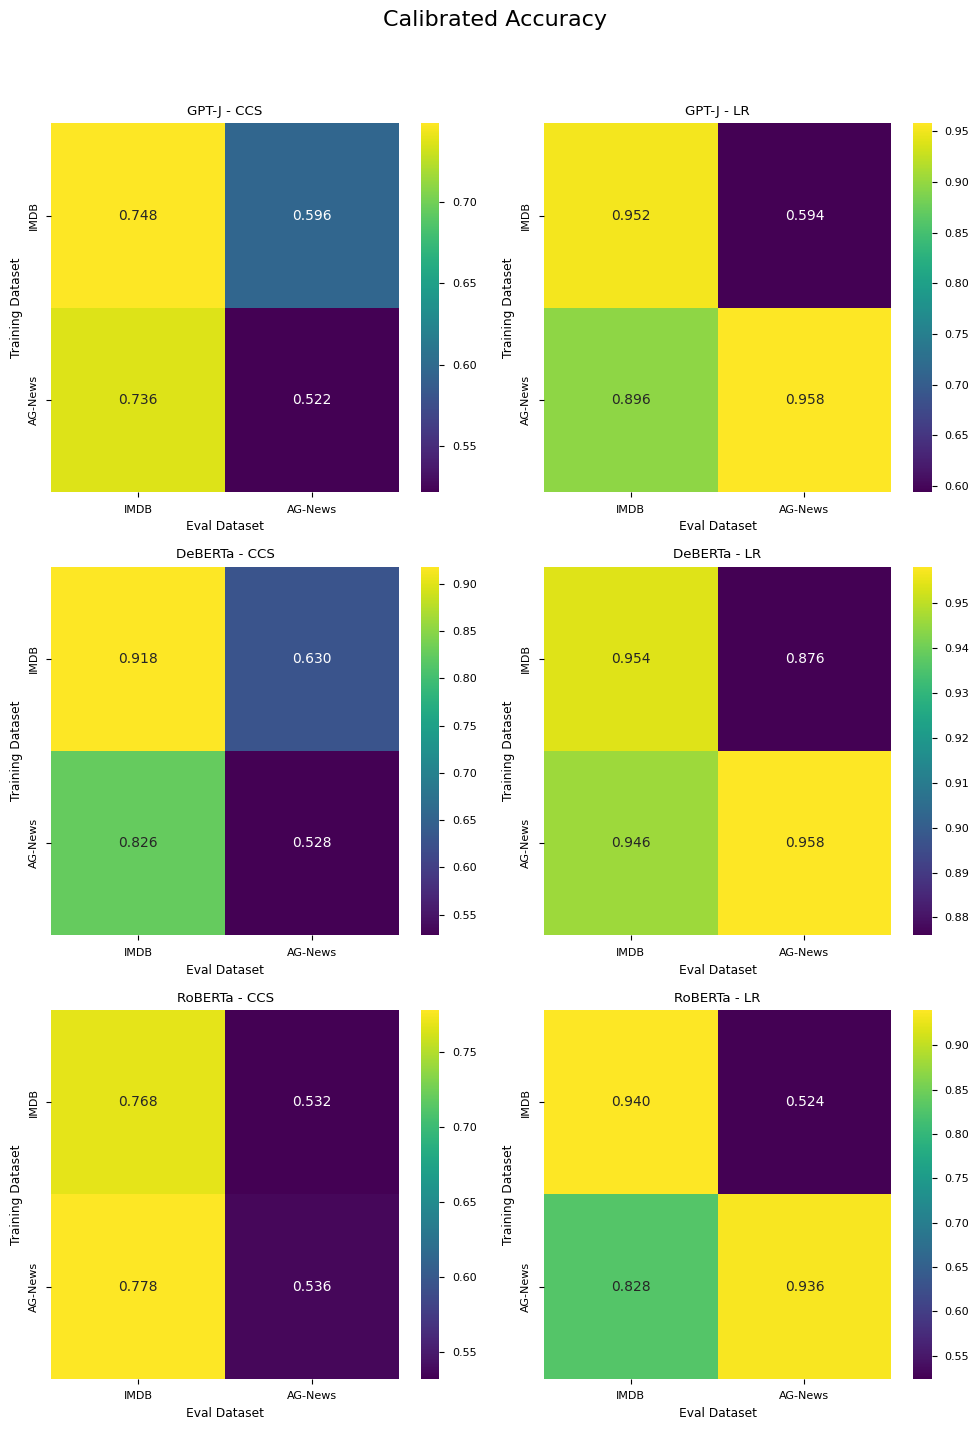

In [108]:
# for ensembling in ENSEMBLING_MODES:
# for ensembling in ["full", "burns", "partial", "none"]:
for ensembling in ["burns", "full"]:
    # for metric in ["acc_estimate", "cal_acc_estimate", "auroc_estimate", "ece"]:
    for metric in ["cal_acc_estimate"]:
        print(f"Ensembling: {ensembling}")
        generate_heatmaps(results_df, metric, layer=None, ensembling=ensembling)